In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_0_t1t2_normalized_e_n_e_1_0_e_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(239503, 828)
(239503, 8)
validation
(42717, 828)
(42717, 8)
test
(21245, 828)
(21245, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/24 [>.............................] - ETA: 37s - loss: 2.0127 - STD: 0.0766 - MAE: 0.2139

 4/24 [====>.........................] - ETA: 0s - loss: 1.6157 - STD: 0.1425 - MAE: 0.1741 

 5/24 [=====>........................] - ETA: 0s - loss: 1.5814 - STD: 0.1614 - MAE: 0.1659

 6/24 [======>.......................] - ETA: 0s - loss: 1.5604 - STD: 0.1740 - MAE: 0.1605

 7/24 [=======>......................] - ETA: 0s - loss: 1.5413 - STD: 0.1817 - MAE: 0.1570

 8/24 [=========>....................] - ETA: 0s - loss: 1.5281 - STD: 0.1855 - MAE: 0.1553

 9/24 [==========>...................] - ETA: 0s - loss: 1.5162 - STD: 0.1865 - MAE: 0.1546

10/24 [===========>..................] - ETA: 2s - loss: 1.5065 - STD: 0.1856 - MAE: 0.1546

13/24 [===============>..............] - ETA: 1s - loss: 1.4890 - STD: 0.1806 - MAE: 0.1559

15/24 [=================>............] - ETA: 1s - loss: 1.4782 - STD: 0.1792 - MAE: 0.1561

16/24 [===================>..........] - ETA: 0s - loss: 1.4741 - STD: 0.1794 - MAE: 0.1559

17/24 [====================>.........] - ETA: 0s - loss: 1.4697 - STD: 0.1801 - MAE: 0.1555

18/24 [=====================>........] - ETA: 0s - loss: 1.4665 - STD: 0.1810 - MAE: 0.1551

19/24 [======================>.......] - ETA: 0s - loss: 1.4629 - STD: 0.1821 - MAE: 0.1546

20/24 [========================>.....] - ETA: 0s - loss: 1.4601 - STD: 0.1832 - MAE: 0.1541

21/24 [=========================>....] - ETA: 0s - loss: 1.4570 - STD: 0.1842 - MAE: 0.1537

22/24 [==========================>...] - ETA: 0s - loss: 1.4538 - STD: 0.1850 - MAE: 0.1533

23/24 [===========================>..] - ETA: 0s - loss: 1.4513 - STD: 0.1855 - MAE: 0.1531

24/24 [==============================] - ETA: 0s - loss: 1.4489 - STD: 0.1856 - MAE: 0.1530

24/24 [==============================] - 5s 127ms/step - loss: 1.4489 - STD: 0.1856 - MAE: 0.1530 - val_loss: 1.3918 - val_STD: 0.1832 - val_MAE: 0.1470


Epoch 2/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.3995 - STD: 0.1832 - MAE: 0.1531

 2/24 [=>............................] - ETA: 1s - loss: 1.3841 - STD: 0.1798 - MAE: 0.1533

 3/24 [==>...........................] - ETA: 1s - loss: 1.3826 - STD: 0.1769 - MAE: 0.1543

 4/24 [====>.........................] - ETA: 1s - loss: 1.3828 - STD: 0.1746 - MAE: 0.1551

 5/24 [=====>........................] - ETA: 1s - loss: 1.3852 - STD: 0.1729 - MAE: 0.1558

 6/24 [======>.......................] - ETA: 1s - loss: 1.3852 - STD: 0.1718 - MAE: 0.1563

 7/24 [=======>......................] - ETA: 1s - loss: 1.3850 - STD: 0.1712 - MAE: 0.1564

 8/24 [=========>....................] - ETA: 0s - loss: 1.3852 - STD: 0.1712 - MAE: 0.1565

 9/24 [==========>...................] - ETA: 0s - loss: 1.3865 - STD: 0.1716 - MAE: 0.1564

10/24 [===========>..................] - ETA: 0s - loss: 1.3866 - STD: 0.1723 - MAE: 0.1562

11/24 [============>.................] - ETA: 0s - loss: 1.3890 - STD: 0.1732 - MAE: 0.1560

12/24 [==============>...............] - ETA: 0s - loss: 1.3878 - STD: 0.1742 - MAE: 0.1556

13/24 [===============>..............] - ETA: 0s - loss: 1.3883 - STD: 0.1751 - MAE: 0.1552

14/24 [================>.............] - ETA: 0s - loss: 1.3884 - STD: 0.1760 - MAE: 0.1549

15/24 [=================>............] - ETA: 0s - loss: 1.3886 - STD: 0.1768 - MAE: 0.1546

16/24 [===================>..........] - ETA: 0s - loss: 1.3880 - STD: 0.1774 - MAE: 0.1544

17/24 [====================>.........] - ETA: 0s - loss: 1.3879 - STD: 0.1778 - MAE: 0.1542

18/24 [=====================>........] - ETA: 0s - loss: 1.3873 - STD: 0.1781 - MAE: 0.1541

19/24 [======================>.......] - ETA: 0s - loss: 1.3874 - STD: 0.1783 - MAE: 0.1540

20/24 [========================>.....] - ETA: 0s - loss: 1.3873 - STD: 0.1784 - MAE: 0.1540

21/24 [=========================>....] - ETA: 0s - loss: 1.3879 - STD: 0.1784 - MAE: 0.1541

22/24 [==========================>...] - ETA: 0s - loss: 1.3883 - STD: 0.1783 - MAE: 0.1541

23/24 [===========================>..] - ETA: 0s - loss: 1.3882 - STD: 0.1783 - MAE: 0.1541

24/24 [==============================] - ETA: 0s - loss: 1.3880 - STD: 0.1782 - MAE: 0.1541

24/24 [==============================] - 2s 65ms/step - loss: 1.3880 - STD: 0.1782 - MAE: 0.1541 - val_loss: 1.3798 - val_STD: 0.1781 - val_MAE: 0.1489


Epoch 3/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.3980 - STD: 0.1780 - MAE: 0.1551

 2/24 [=>............................] - ETA: 1s - loss: 1.3961 - STD: 0.1783 - MAE: 0.1548

 3/24 [==>...........................] - ETA: 1s - loss: 1.3938 - STD: 0.1788 - MAE: 0.1544

 4/24 [====>.........................] - ETA: 1s - loss: 1.3938 - STD: 0.1793 - MAE: 0.1542

 5/24 [=====>........................] - ETA: 1s - loss: 1.3906 - STD: 0.1798 - MAE: 0.1538

 6/24 [======>.......................] - ETA: 1s - loss: 1.3860 - STD: 0.1803 - MAE: 0.1534

 7/24 [=======>......................] - ETA: 0s - loss: 1.3847 - STD: 0.1809 - MAE: 0.1530

 8/24 [=========>....................] - ETA: 0s - loss: 1.3865 - STD: 0.1814 - MAE: 0.1530

 9/24 [==========>...................] - ETA: 0s - loss: 1.3860 - STD: 0.1818 - MAE: 0.1528

10/24 [===========>..................] - ETA: 0s - loss: 1.3873 - STD: 0.1820 - MAE: 0.1528

11/24 [============>.................] - ETA: 0s - loss: 1.3882 - STD: 0.1821 - MAE: 0.1528

12/24 [==============>...............] - ETA: 0s - loss: 1.3877 - STD: 0.1820 - MAE: 0.1528

13/24 [===============>..............] - ETA: 0s - loss: 1.3871 - STD: 0.1817 - MAE: 0.1529

14/24 [================>.............] - ETA: 0s - loss: 1.3868 - STD: 0.1814 - MAE: 0.1530

15/24 [=================>............] - ETA: 0s - loss: 1.3872 - STD: 0.1810 - MAE: 0.1531

16/24 [===================>..........] - ETA: 0s - loss: 1.3862 - STD: 0.1808 - MAE: 0.1532

17/24 [====================>.........] - ETA: 0s - loss: 1.3854 - STD: 0.1806 - MAE: 0.1532

18/24 [=====================>........] - ETA: 0s - loss: 1.3848 - STD: 0.1805 - MAE: 0.1532

19/24 [======================>.......] - ETA: 0s - loss: 1.3849 - STD: 0.1806 - MAE: 0.1532

20/24 [========================>.....] - ETA: 0s - loss: 1.3843 - STD: 0.1807 - MAE: 0.1531

22/24 [==========================>...] - ETA: 0s - loss: 1.3827 - STD: 0.1809 - MAE: 0.1529

23/24 [===========================>..] - ETA: 0s - loss: 1.3823 - STD: 0.1810 - MAE: 0.1529

24/24 [==============================] - ETA: 0s - loss: 1.3812 - STD: 0.1811 - MAE: 0.1528

24/24 [==============================] - 2s 68ms/step - loss: 1.3812 - STD: 0.1811 - MAE: 0.1528 - val_loss: 1.3671 - val_STD: 0.1830 - val_MAE: 0.1461


Epoch 4/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.3923 - STD: 0.1818 - MAE: 0.1534

 2/24 [=>............................] - ETA: 1s - loss: 1.3899 - STD: 0.1811 - MAE: 0.1532

 3/24 [==>...........................] - ETA: 1s - loss: 1.3844 - STD: 0.1804 - MAE: 0.1531

 4/24 [====>.........................] - ETA: 1s - loss: 1.3720 - STD: 0.1799 - MAE: 0.1527

 5/24 [=====>........................] - ETA: 1s - loss: 1.3707 - STD: 0.1799 - MAE: 0.1526

 6/24 [======>.......................] - ETA: 1s - loss: 1.3681 - STD: 0.1801 - MAE: 0.1524

 7/24 [=======>......................] - ETA: 1s - loss: 1.3673 - STD: 0.1804 - MAE: 0.1522

 8/24 [=========>....................] - ETA: 0s - loss: 1.3649 - STD: 0.1808 - MAE: 0.1519

 9/24 [==========>...................] - ETA: 0s - loss: 1.3630 - STD: 0.1810 - MAE: 0.1517

10/24 [===========>..................] - ETA: 0s - loss: 1.3607 - STD: 0.1812 - MAE: 0.1515

11/24 [============>.................] - ETA: 0s - loss: 1.3582 - STD: 0.1813 - MAE: 0.1514

12/24 [==============>...............] - ETA: 0s - loss: 1.3584 - STD: 0.1813 - MAE: 0.1513

13/24 [===============>..............] - ETA: 0s - loss: 1.3555 - STD: 0.1813 - MAE: 0.1511

14/24 [================>.............] - ETA: 0s - loss: 1.3551 - STD: 0.1814 - MAE: 0.1511

15/24 [=================>............] - ETA: 0s - loss: 1.3534 - STD: 0.1815 - MAE: 0.1509

16/24 [===================>..........] - ETA: 0s - loss: 1.3514 - STD: 0.1817 - MAE: 0.1507

17/24 [====================>.........] - ETA: 0s - loss: 1.3499 - STD: 0.1818 - MAE: 0.1506

18/24 [=====================>........] - ETA: 0s - loss: 1.3484 - STD: 0.1821 - MAE: 0.1504

19/24 [======================>.......] - ETA: 0s - loss: 1.3470 - STD: 0.1823 - MAE: 0.1502

20/24 [========================>.....] - ETA: 0s - loss: 1.3444 - STD: 0.1825 - MAE: 0.1500

21/24 [=========================>....] - ETA: 0s - loss: 1.3427 - STD: 0.1828 - MAE: 0.1498

22/24 [==========================>...] - ETA: 0s - loss: 1.3420 - STD: 0.1832 - MAE: 0.1496

23/24 [===========================>..] - ETA: 0s - loss: 1.3409 - STD: 0.1835 - MAE: 0.1495

24/24 [==============================] - ETA: 0s - loss: 1.3397 - STD: 0.1837 - MAE: 0.1493

24/24 [==============================] - 2s 64ms/step - loss: 1.3397 - STD: 0.1837 - MAE: 0.1493 - val_loss: 1.3082 - val_STD: 0.1951 - val_MAE: 0.1364


Epoch 5/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.3131 - STD: 0.1889 - MAE: 0.1459

 2/24 [=>............................] - ETA: 1s - loss: 1.3026 - STD: 0.1895 - MAE: 0.1450

 3/24 [==>...........................] - ETA: 1s - loss: 1.3074 - STD: 0.1905 - MAE: 0.1450

 4/24 [====>.........................] - ETA: 1s - loss: 1.3093 - STD: 0.1911 - MAE: 0.1449

 5/24 [=====>........................] - ETA: 1s - loss: 1.3048 - STD: 0.1914 - MAE: 0.1446

 6/24 [======>.......................] - ETA: 1s - loss: 1.3055 - STD: 0.1911 - MAE: 0.1448

 7/24 [=======>......................] - ETA: 0s - loss: 1.3047 - STD: 0.1909 - MAE: 0.1448

 8/24 [=========>....................] - ETA: 0s - loss: 1.3042 - STD: 0.1908 - MAE: 0.1448

 9/24 [==========>...................] - ETA: 0s - loss: 1.3018 - STD: 0.1909 - MAE: 0.1447

10/24 [===========>..................] - ETA: 0s - loss: 1.3017 - STD: 0.1911 - MAE: 0.1446

11/24 [============>.................] - ETA: 0s - loss: 1.3002 - STD: 0.1912 - MAE: 0.1445

12/24 [==============>...............] - ETA: 0s - loss: 1.3000 - STD: 0.1911 - MAE: 0.1445

13/24 [===============>..............] - ETA: 0s - loss: 1.2972 - STD: 0.1913 - MAE: 0.1442

14/24 [================>.............] - ETA: 0s - loss: 1.2974 - STD: 0.1918 - MAE: 0.1440

15/24 [=================>............] - ETA: 0s - loss: 1.2967 - STD: 0.1923 - MAE: 0.1439

16/24 [===================>..........] - ETA: 0s - loss: 1.2949 - STD: 0.1922 - MAE: 0.1438

17/24 [====================>.........] - ETA: 0s - loss: 1.2948 - STD: 0.1922 - MAE: 0.1438

18/24 [=====================>........] - ETA: 0s - loss: 1.2942 - STD: 0.1923 - MAE: 0.1437

19/24 [======================>.......] - ETA: 0s - loss: 1.2924 - STD: 0.1924 - MAE: 0.1436

20/24 [========================>.....] - ETA: 0s - loss: 1.2914 - STD: 0.1925 - MAE: 0.1435

21/24 [=========================>....] - ETA: 0s - loss: 1.2915 - STD: 0.1925 - MAE: 0.1435

22/24 [==========================>...] - ETA: 0s - loss: 1.2911 - STD: 0.1922 - MAE: 0.1436

23/24 [===========================>..] - ETA: 0s - loss: 1.2908 - STD: 0.1920 - MAE: 0.1437

24/24 [==============================] - ETA: 0s - loss: 1.2896 - STD: 0.1922 - MAE: 0.1435

24/24 [==============================] - 2s 65ms/step - loss: 1.2896 - STD: 0.1922 - MAE: 0.1435 - val_loss: 1.2821 - val_STD: 0.2038 - val_MAE: 0.1309


Epoch 6/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.2826 - STD: 0.2015 - MAE: 0.1399

 2/24 [=>............................] - ETA: 1s - loss: 1.2665 - STD: 0.1990 - MAE: 0.1398

 3/24 [==>...........................] - ETA: 1s - loss: 1.2653 - STD: 0.1971 - MAE: 0.1405

 4/24 [====>.........................] - ETA: 1s - loss: 1.2705 - STD: 0.1968 - MAE: 0.1409

 5/24 [=====>........................] - ETA: 1s - loss: 1.2691 - STD: 0.1970 - MAE: 0.1408

 6/24 [======>.......................] - ETA: 1s - loss: 1.2664 - STD: 0.1968 - MAE: 0.1407

 7/24 [=======>......................] - ETA: 0s - loss: 1.2648 - STD: 0.1968 - MAE: 0.1407

 8/24 [=========>....................] - ETA: 0s - loss: 1.2626 - STD: 0.1965 - MAE: 0.1406

 9/24 [==========>...................] - ETA: 0s - loss: 1.2617 - STD: 0.1962 - MAE: 0.1407

10/24 [===========>..................] - ETA: 0s - loss: 1.2611 - STD: 0.1965 - MAE: 0.1406

11/24 [============>.................] - ETA: 0s - loss: 1.2624 - STD: 0.1963 - MAE: 0.1408

12/24 [==============>...............] - ETA: 0s - loss: 1.2627 - STD: 0.1957 - MAE: 0.1410

13/24 [===============>..............] - ETA: 0s - loss: 1.2608 - STD: 0.1958 - MAE: 0.1409

14/24 [================>.............] - ETA: 0s - loss: 1.2625 - STD: 0.1966 - MAE: 0.1407

15/24 [=================>............] - ETA: 0s - loss: 1.2615 - STD: 0.1960 - MAE: 0.1408

16/24 [===================>..........] - ETA: 0s - loss: 1.2595 - STD: 0.1957 - MAE: 0.1408

17/24 [====================>.........] - ETA: 0s - loss: 1.2593 - STD: 0.1962 - MAE: 0.1407

18/24 [=====================>........] - ETA: 0s - loss: 1.2583 - STD: 0.1965 - MAE: 0.1405

19/24 [======================>.......] - ETA: 0s - loss: 1.2568 - STD: 0.1963 - MAE: 0.1405

20/24 [========================>.....] - ETA: 0s - loss: 1.2553 - STD: 0.1962 - MAE: 0.1404

21/24 [=========================>....] - ETA: 0s - loss: 1.2542 - STD: 0.1968 - MAE: 0.1401

22/24 [==========================>...] - ETA: 0s - loss: 1.2530 - STD: 0.1968 - MAE: 0.1400

23/24 [===========================>..] - ETA: 0s - loss: 1.2526 - STD: 0.1966 - MAE: 0.1401

24/24 [==============================] - ETA: 0s - loss: 1.2513 - STD: 0.1967 - MAE: 0.1400

24/24 [==============================] - 2s 66ms/step - loss: 1.2513 - STD: 0.1967 - MAE: 0.1400 - val_loss: 1.2446 - val_STD: 0.2072 - val_MAE: 0.1268


Epoch 7/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.2079 - STD: 0.2075 - MAE: 0.1334

 2/24 [=>............................] - ETA: 1s - loss: 1.2192 - STD: 0.2000 - MAE: 0.1371

 3/24 [==>...........................] - ETA: 1s - loss: 1.2196 - STD: 0.1979 - MAE: 0.1380

 4/24 [====>.........................] - ETA: 1s - loss: 1.2178 - STD: 0.2007 - MAE: 0.1368

 5/24 [=====>........................] - ETA: 1s - loss: 1.2175 - STD: 0.1994 - MAE: 0.1374

 6/24 [======>.......................] - ETA: 1s - loss: 1.2126 - STD: 0.1988 - MAE: 0.1373

 7/24 [=======>......................] - ETA: 0s - loss: 1.2129 - STD: 0.2010 - MAE: 0.1365

 8/24 [=========>....................] - ETA: 0s - loss: 1.2114 - STD: 0.1993 - MAE: 0.1371

 9/24 [==========>...................] - ETA: 0s - loss: 1.2099 - STD: 0.1992 - MAE: 0.1370

10/24 [===========>..................] - ETA: 0s - loss: 1.2082 - STD: 0.2009 - MAE: 0.1363

11/24 [============>.................] - ETA: 0s - loss: 1.2058 - STD: 0.2002 - MAE: 0.1365

12/24 [==============>...............] - ETA: 0s - loss: 1.2050 - STD: 0.1998 - MAE: 0.1366

13/24 [===============>..............] - ETA: 0s - loss: 1.2037 - STD: 0.2007 - MAE: 0.1362

14/24 [================>.............] - ETA: 0s - loss: 1.2032 - STD: 0.2005 - MAE: 0.1362

15/24 [=================>............] - ETA: 0s - loss: 1.2008 - STD: 0.2001 - MAE: 0.1363

16/24 [===================>..........] - ETA: 0s - loss: 1.2003 - STD: 0.2008 - MAE: 0.1360

17/24 [====================>.........] - ETA: 0s - loss: 1.2006 - STD: 0.2010 - MAE: 0.1360

18/24 [=====================>........] - ETA: 0s - loss: 1.1983 - STD: 0.2005 - MAE: 0.1361

19/24 [======================>.......] - ETA: 0s - loss: 1.1969 - STD: 0.2009 - MAE: 0.1359

20/24 [========================>.....] - ETA: 0s - loss: 1.1947 - STD: 0.2014 - MAE: 0.1356

21/24 [=========================>....] - ETA: 0s - loss: 1.1941 - STD: 0.2013 - MAE: 0.1357

22/24 [==========================>...] - ETA: 0s - loss: 1.1924 - STD: 0.2013 - MAE: 0.1356

23/24 [===========================>..] - ETA: 0s - loss: 1.1910 - STD: 0.2016 - MAE: 0.1354

24/24 [==============================] - ETA: 0s - loss: 1.1896 - STD: 0.2017 - MAE: 0.1353

24/24 [==============================] - 2s 64ms/step - loss: 1.1896 - STD: 0.2017 - MAE: 0.1353 - val_loss: 1.1922 - val_STD: 0.2020 - val_MAE: 0.1275


Epoch 8/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.1747 - STD: 0.2001 - MAE: 0.1357

 2/24 [=>............................] - ETA: 1s - loss: 1.1684 - STD: 0.2032 - MAE: 0.1343

 3/24 [==>...........................] - ETA: 1s - loss: 1.1645 - STD: 0.2035 - MAE: 0.1340

 4/24 [====>.........................] - ETA: 1s - loss: 1.1694 - STD: 0.2035 - MAE: 0.1343

 5/24 [=====>........................] - ETA: 1s - loss: 1.1661 - STD: 0.2026 - MAE: 0.1346

 6/24 [======>.......................] - ETA: 0s - loss: 1.1595 - STD: 0.2036 - MAE: 0.1338

 7/24 [=======>......................] - ETA: 0s - loss: 1.1573 - STD: 0.2057 - MAE: 0.1329

 8/24 [=========>....................] - ETA: 0s - loss: 1.1538 - STD: 0.2046 - MAE: 0.1332

 9/24 [==========>...................] - ETA: 0s - loss: 1.1538 - STD: 0.2045 - MAE: 0.1332

10/24 [===========>..................] - ETA: 0s - loss: 1.1524 - STD: 0.2055 - MAE: 0.1328

11/24 [============>.................] - ETA: 0s - loss: 1.1504 - STD: 0.2057 - MAE: 0.1326

12/24 [==============>...............] - ETA: 0s - loss: 1.1491 - STD: 0.2056 - MAE: 0.1326

13/24 [===============>..............] - ETA: 0s - loss: 1.1461 - STD: 0.2060 - MAE: 0.1323

14/24 [================>.............] - ETA: 0s - loss: 1.1435 - STD: 0.2066 - MAE: 0.1319

15/24 [=================>............] - ETA: 0s - loss: 1.1424 - STD: 0.2068 - MAE: 0.1318

16/24 [===================>..........] - ETA: 0s - loss: 1.1414 - STD: 0.2063 - MAE: 0.1320

17/24 [====================>.........] - ETA: 0s - loss: 1.1394 - STD: 0.2067 - MAE: 0.1317

18/24 [=====================>........] - ETA: 0s - loss: 1.1392 - STD: 0.2072 - MAE: 0.1315

19/24 [======================>.......] - ETA: 0s - loss: 1.1386 - STD: 0.2067 - MAE: 0.1317

20/24 [========================>.....] - ETA: 0s - loss: 1.1370 - STD: 0.2066 - MAE: 0.1317

21/24 [=========================>....] - ETA: 0s - loss: 1.1369 - STD: 0.2074 - MAE: 0.1314

22/24 [==========================>...] - ETA: 0s - loss: 1.1354 - STD: 0.2073 - MAE: 0.1314

23/24 [===========================>..] - ETA: 0s - loss: 1.1335 - STD: 0.2071 - MAE: 0.1314

24/24 [==============================] - ETA: 0s - loss: 1.1327 - STD: 0.2074 - MAE: 0.1312

24/24 [==============================] - 2s 63ms/step - loss: 1.1327 - STD: 0.2074 - MAE: 0.1312 - val_loss: 1.1717 - val_STD: 0.2190 - val_MAE: 0.1196


Epoch 9/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.0967 - STD: 0.2179 - MAE: 0.1253

 2/24 [=>............................] - ETA: 1s - loss: 1.1098 - STD: 0.2117 - MAE: 0.1285

 3/24 [==>...........................] - ETA: 1s - loss: 1.1131 - STD: 0.2084 - MAE: 0.1301

 4/24 [====>.........................] - ETA: 1s - loss: 1.1129 - STD: 0.2091 - MAE: 0.1299

 5/24 [=====>........................] - ETA: 1s - loss: 1.1132 - STD: 0.2108 - MAE: 0.1293

 6/24 [======>.......................] - ETA: 1s - loss: 1.1134 - STD: 0.2100 - MAE: 0.1297

 7/24 [=======>......................] - ETA: 0s - loss: 1.1125 - STD: 0.2093 - MAE: 0.1299

 8/24 [=========>....................] - ETA: 0s - loss: 1.1137 - STD: 0.2095 - MAE: 0.1298

 9/24 [==========>...................] - ETA: 0s - loss: 1.1142 - STD: 0.2097 - MAE: 0.1298

10/24 [===========>..................] - ETA: 0s - loss: 1.1130 - STD: 0.2093 - MAE: 0.1299

11/24 [============>.................] - ETA: 0s - loss: 1.1108 - STD: 0.2094 - MAE: 0.1298

12/24 [==============>...............] - ETA: 0s - loss: 1.1089 - STD: 0.2095 - MAE: 0.1297

13/24 [===============>..............] - ETA: 0s - loss: 1.1078 - STD: 0.2097 - MAE: 0.1296

14/24 [================>.............] - ETA: 0s - loss: 1.1072 - STD: 0.2099 - MAE: 0.1294

15/24 [=================>............] - ETA: 0s - loss: 1.1065 - STD: 0.2100 - MAE: 0.1294

16/24 [===================>..........] - ETA: 0s - loss: 1.1058 - STD: 0.2101 - MAE: 0.1293

17/24 [====================>.........] - ETA: 0s - loss: 1.1061 - STD: 0.2102 - MAE: 0.1293

18/24 [=====================>........] - ETA: 0s - loss: 1.1052 - STD: 0.2102 - MAE: 0.1292

19/24 [======================>.......] - ETA: 0s - loss: 1.1043 - STD: 0.2104 - MAE: 0.1291

20/24 [========================>.....] - ETA: 0s - loss: 1.1026 - STD: 0.2103 - MAE: 0.1291

21/24 [=========================>....] - ETA: 0s - loss: 1.1022 - STD: 0.2102 - MAE: 0.1291

22/24 [==========================>...] - ETA: 0s - loss: 1.1020 - STD: 0.2103 - MAE: 0.1291

23/24 [===========================>..] - ETA: 0s - loss: 1.1015 - STD: 0.2103 - MAE: 0.1291

24/24 [==============================] - ETA: 0s - loss: 1.1009 - STD: 0.2103 - MAE: 0.1290

24/24 [==============================] - 2s 65ms/step - loss: 1.1009 - STD: 0.2103 - MAE: 0.1290 - val_loss: 1.1768 - val_STD: 0.2159 - val_MAE: 0.1214


Epoch 10/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.0683 - STD: 0.2144 - MAE: 0.1258

 2/24 [=>............................] - ETA: 1s - loss: 1.0842 - STD: 0.2145 - MAE: 0.1266

 3/24 [==>...........................] - ETA: 1s - loss: 1.0831 - STD: 0.2124 - MAE: 0.1275

 4/24 [====>.........................] - ETA: 1s - loss: 1.0821 - STD: 0.2127 - MAE: 0.1273

 5/24 [=====>........................] - ETA: 1s - loss: 1.0829 - STD: 0.2122 - MAE: 0.1275

 6/24 [======>.......................] - ETA: 0s - loss: 1.0846 - STD: 0.2119 - MAE: 0.1278

 7/24 [=======>......................] - ETA: 0s - loss: 1.0837 - STD: 0.2120 - MAE: 0.1277

 8/24 [=========>....................] - ETA: 0s - loss: 1.0844 - STD: 0.2123 - MAE: 0.1276

 9/24 [==========>...................] - ETA: 0s - loss: 1.0826 - STD: 0.2116 - MAE: 0.1279

10/24 [===========>..................] - ETA: 0s - loss: 1.0830 - STD: 0.2117 - MAE: 0.1279

11/24 [============>.................] - ETA: 0s - loss: 1.0817 - STD: 0.2121 - MAE: 0.1277

12/24 [==============>...............] - ETA: 0s - loss: 1.0817 - STD: 0.2118 - MAE: 0.1278

13/24 [===============>..............] - ETA: 0s - loss: 1.0809 - STD: 0.2115 - MAE: 0.1279

14/24 [================>.............] - ETA: 0s - loss: 1.0797 - STD: 0.2119 - MAE: 0.1277

15/24 [=================>............] - ETA: 0s - loss: 1.0787 - STD: 0.2120 - MAE: 0.1277

16/24 [===================>..........] - ETA: 0s - loss: 1.0769 - STD: 0.2117 - MAE: 0.1277

17/24 [====================>.........] - ETA: 0s - loss: 1.0773 - STD: 0.2118 - MAE: 0.1277

18/24 [=====================>........] - ETA: 0s - loss: 1.0765 - STD: 0.2119 - MAE: 0.1276

19/24 [======================>.......] - ETA: 0s - loss: 1.0754 - STD: 0.2119 - MAE: 0.1276

20/24 [========================>.....] - ETA: 0s - loss: 1.0750 - STD: 0.2120 - MAE: 0.1275

21/24 [=========================>....] - ETA: 0s - loss: 1.0739 - STD: 0.2121 - MAE: 0.1274

22/24 [==========================>...] - ETA: 0s - loss: 1.0728 - STD: 0.2121 - MAE: 0.1274

23/24 [===========================>..] - ETA: 0s - loss: 1.0724 - STD: 0.2122 - MAE: 0.1273

24/24 [==============================] - ETA: 0s - loss: 1.0717 - STD: 0.2121 - MAE: 0.1274

24/24 [==============================] - 2s 69ms/step - loss: 1.0717 - STD: 0.2121 - MAE: 0.1274 - val_loss: 1.1583 - val_STD: 0.2180 - val_MAE: 0.1194


Epoch 11/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.0496 - STD: 0.2149 - MAE: 0.1254

 2/24 [=>............................] - ETA: 1s - loss: 1.0514 - STD: 0.2145 - MAE: 0.1256

 3/24 [==>...........................] - ETA: 1s - loss: 1.0547 - STD: 0.2144 - MAE: 0.1259

 4/24 [====>.........................] - ETA: 1s - loss: 1.0561 - STD: 0.2130 - MAE: 0.1265

 5/24 [=====>........................] - ETA: 1s - loss: 1.0589 - STD: 0.2129 - MAE: 0.1267

 6/24 [======>.......................] - ETA: 1s - loss: 1.0553 - STD: 0.2128 - MAE: 0.1266

 7/24 [=======>......................] - ETA: 1s - loss: 1.0558 - STD: 0.2136 - MAE: 0.1262

 8/24 [=========>....................] - ETA: 1s - loss: 1.0569 - STD: 0.2125 - MAE: 0.1267

 9/24 [==========>...................] - ETA: 0s - loss: 1.0556 - STD: 0.2133 - MAE: 0.1263

10/24 [===========>..................] - ETA: 0s - loss: 1.0530 - STD: 0.2136 - MAE: 0.1260

11/24 [============>.................] - ETA: 0s - loss: 1.0517 - STD: 0.2136 - MAE: 0.1260

12/24 [==============>...............] - ETA: 0s - loss: 1.0502 - STD: 0.2138 - MAE: 0.1258

13/24 [===============>..............] - ETA: 0s - loss: 1.0487 - STD: 0.2138 - MAE: 0.1258

14/24 [================>.............] - ETA: 0s - loss: 1.0480 - STD: 0.2137 - MAE: 0.1257

15/24 [=================>............] - ETA: 0s - loss: 1.0484 - STD: 0.2142 - MAE: 0.1256

16/24 [===================>..........] - ETA: 0s - loss: 1.0470 - STD: 0.2139 - MAE: 0.1256

17/24 [====================>.........] - ETA: 0s - loss: 1.0460 - STD: 0.2136 - MAE: 0.1257

18/24 [=====================>........] - ETA: 0s - loss: 1.0456 - STD: 0.2142 - MAE: 0.1254

19/24 [======================>.......] - ETA: 0s - loss: 1.0446 - STD: 0.2144 - MAE: 0.1254

20/24 [========================>.....] - ETA: 0s - loss: 1.0441 - STD: 0.2139 - MAE: 0.1255

21/24 [=========================>....] - ETA: 0s - loss: 1.0433 - STD: 0.2141 - MAE: 0.1254

22/24 [==========================>...] - ETA: 0s - loss: 1.0415 - STD: 0.2143 - MAE: 0.1253

23/24 [===========================>..] - ETA: 0s - loss: 1.0406 - STD: 0.2142 - MAE: 0.1253

24/24 [==============================] - ETA: 0s - loss: 1.0389 - STD: 0.2142 - MAE: 0.1252

24/24 [==============================] - 2s 69ms/step - loss: 1.0389 - STD: 0.2142 - MAE: 0.1252 - val_loss: 1.1280 - val_STD: 0.2282 - val_MAE: 0.1133


Epoch 12/10000


 1/24 [>.............................] - ETA: 2s - loss: 1.0334 - STD: 0.2251 - MAE: 0.1205

 2/24 [=>............................] - ETA: 1s - loss: 1.0248 - STD: 0.2192 - MAE: 0.1228

 3/24 [==>...........................] - ETA: 1s - loss: 1.0234 - STD: 0.2153 - MAE: 0.1245

 4/24 [====>.........................] - ETA: 1s - loss: 1.0181 - STD: 0.2168 - MAE: 0.1235

 5/24 [=====>........................] - ETA: 1s - loss: 1.0163 - STD: 0.2183 - MAE: 0.1228

 6/24 [======>.......................] - ETA: 1s - loss: 1.0153 - STD: 0.2168 - MAE: 0.1234

 7/24 [=======>......................] - ETA: 1s - loss: 1.0126 - STD: 0.2163 - MAE: 0.1235

 8/24 [=========>....................] - ETA: 1s - loss: 1.0125 - STD: 0.2178 - MAE: 0.1228

 9/24 [==========>...................] - ETA: 1s - loss: 1.0109 - STD: 0.2171 - MAE: 0.1231

10/24 [===========>..................] - ETA: 0s - loss: 1.0094 - STD: 0.2166 - MAE: 0.1232

11/24 [============>.................] - ETA: 0s - loss: 1.0076 - STD: 0.2175 - MAE: 0.1228

12/24 [==============>...............] - ETA: 0s - loss: 1.0073 - STD: 0.2178 - MAE: 0.1227

13/24 [===============>..............] - ETA: 0s - loss: 1.0068 - STD: 0.2169 - MAE: 0.1230

14/24 [================>.............] - ETA: 0s - loss: 1.0077 - STD: 0.2170 - MAE: 0.1230

15/24 [=================>............] - ETA: 0s - loss: 1.0078 - STD: 0.2179 - MAE: 0.1226

16/24 [===================>..........] - ETA: 0s - loss: 1.0066 - STD: 0.2175 - MAE: 0.1228

17/24 [====================>.........] - ETA: 0s - loss: 1.0058 - STD: 0.2172 - MAE: 0.1228

18/24 [=====================>........] - ETA: 0s - loss: 1.0041 - STD: 0.2178 - MAE: 0.1226

19/24 [======================>.......] - ETA: 0s - loss: 1.0030 - STD: 0.2179 - MAE: 0.1224

20/24 [========================>.....] - ETA: 0s - loss: 1.0027 - STD: 0.2178 - MAE: 0.1225

21/24 [=========================>....] - ETA: 0s - loss: 1.0016 - STD: 0.2176 - MAE: 0.1225

22/24 [==========================>...] - ETA: 0s - loss: 1.0013 - STD: 0.2179 - MAE: 0.1224

23/24 [===========================>..] - ETA: 0s - loss: 0.9999 - STD: 0.2182 - MAE: 0.1222

24/24 [==============================] - ETA: 0s - loss: 0.9985 - STD: 0.2181 - MAE: 0.1222

24/24 [==============================] - 2s 72ms/step - loss: 0.9985 - STD: 0.2181 - MAE: 0.1222 - val_loss: 1.1329 - val_STD: 0.2217 - val_MAE: 0.1180


Epoch 13/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.9500 - STD: 0.2172 - MAE: 0.1204

 2/24 [=>............................] - ETA: 1s - loss: 0.9592 - STD: 0.2217 - MAE: 0.1191

 3/24 [==>...........................] - ETA: 1s - loss: 0.9657 - STD: 0.2224 - MAE: 0.1191

 4/24 [====>.........................] - ETA: 1s - loss: 0.9660 - STD: 0.2194 - MAE: 0.1205

 5/24 [=====>........................] - ETA: 1s - loss: 0.9660 - STD: 0.2190 - MAE: 0.1207

 6/24 [======>.......................] - ETA: 1s - loss: 0.9668 - STD: 0.2209 - MAE: 0.1199

 7/24 [=======>......................] - ETA: 1s - loss: 0.9662 - STD: 0.2210 - MAE: 0.1198

 8/24 [=========>....................] - ETA: 1s - loss: 0.9643 - STD: 0.2197 - MAE: 0.1203

 9/24 [==========>...................] - ETA: 0s - loss: 0.9637 - STD: 0.2201 - MAE: 0.1200

10/24 [===========>..................] - ETA: 0s - loss: 0.9648 - STD: 0.2212 - MAE: 0.1196

11/24 [============>.................] - ETA: 0s - loss: 0.9656 - STD: 0.2206 - MAE: 0.1199

12/24 [==============>...............] - ETA: 0s - loss: 0.9661 - STD: 0.2198 - MAE: 0.1203

13/24 [===============>..............] - ETA: 0s - loss: 0.9644 - STD: 0.2203 - MAE: 0.1200

14/24 [================>.............] - ETA: 0s - loss: 0.9643 - STD: 0.2211 - MAE: 0.1197

15/24 [=================>............] - ETA: 0s - loss: 0.9640 - STD: 0.2207 - MAE: 0.1199

16/24 [===================>..........] - ETA: 0s - loss: 0.9637 - STD: 0.2203 - MAE: 0.1200

17/24 [====================>.........] - ETA: 0s - loss: 0.9627 - STD: 0.2205 - MAE: 0.1199

18/24 [=====================>........] - ETA: 0s - loss: 0.9628 - STD: 0.2208 - MAE: 0.1198

19/24 [======================>.......] - ETA: 0s - loss: 0.9631 - STD: 0.2207 - MAE: 0.1199

20/24 [========================>.....] - ETA: 0s - loss: 0.9629 - STD: 0.2204 - MAE: 0.1200

21/24 [=========================>....] - ETA: 0s - loss: 0.9630 - STD: 0.2203 - MAE: 0.1201

22/24 [==========================>...] - ETA: 0s - loss: 0.9625 - STD: 0.2207 - MAE: 0.1199

23/24 [===========================>..] - ETA: 0s - loss: 0.9624 - STD: 0.2207 - MAE: 0.1199

24/24 [==============================] - ETA: 0s - loss: 0.9625 - STD: 0.2203 - MAE: 0.1201

24/24 [==============================] - 2s 69ms/step - loss: 0.9625 - STD: 0.2203 - MAE: 0.1201 - val_loss: 1.1298 - val_STD: 0.2262 - val_MAE: 0.1160


Epoch 14/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.9510 - STD: 0.2197 - MAE: 0.1202

 2/24 [=>............................] - ETA: 1s - loss: 0.9586 - STD: 0.2240 - MAE: 0.1188

 3/24 [==>...........................] - ETA: 1s - loss: 0.9547 - STD: 0.2228 - MAE: 0.1191

 4/24 [====>.........................] - ETA: 1s - loss: 0.9543 - STD: 0.2201 - MAE: 0.1202

 5/24 [=====>........................] - ETA: 1s - loss: 0.9503 - STD: 0.2209 - MAE: 0.1197

 6/24 [======>.......................] - ETA: 1s - loss: 0.9492 - STD: 0.2230 - MAE: 0.1187

 7/24 [=======>......................] - ETA: 1s - loss: 0.9488 - STD: 0.2221 - MAE: 0.1190

 8/24 [=========>....................] - ETA: 1s - loss: 0.9465 - STD: 0.2210 - MAE: 0.1194

 9/24 [==========>...................] - ETA: 1s - loss: 0.9474 - STD: 0.2220 - MAE: 0.1190

10/24 [===========>..................] - ETA: 0s - loss: 0.9469 - STD: 0.2224 - MAE: 0.1188

11/24 [============>.................] - ETA: 0s - loss: 0.9466 - STD: 0.2219 - MAE: 0.1190

12/24 [==============>...............] - ETA: 0s - loss: 0.9473 - STD: 0.2217 - MAE: 0.1191

13/24 [===============>..............] - ETA: 0s - loss: 0.9472 - STD: 0.2220 - MAE: 0.1190

14/24 [================>.............] - ETA: 0s - loss: 0.9455 - STD: 0.2223 - MAE: 0.1188

15/24 [=================>............] - ETA: 0s - loss: 0.9474 - STD: 0.2222 - MAE: 0.1189

16/24 [===================>..........] - ETA: 0s - loss: 0.9480 - STD: 0.2215 - MAE: 0.1192

17/24 [====================>.........] - ETA: 0s - loss: 0.9473 - STD: 0.2221 - MAE: 0.1189

18/24 [=====================>........] - ETA: 0s - loss: 0.9476 - STD: 0.2223 - MAE: 0.1188

19/24 [======================>.......] - ETA: 0s - loss: 0.9474 - STD: 0.2220 - MAE: 0.1189

20/24 [========================>.....] - ETA: 0s - loss: 0.9473 - STD: 0.2220 - MAE: 0.1190

21/24 [=========================>....] - ETA: 0s - loss: 0.9468 - STD: 0.2222 - MAE: 0.1189

22/24 [==========================>...] - ETA: 0s - loss: 0.9460 - STD: 0.2225 - MAE: 0.1187

23/24 [===========================>..] - ETA: 0s - loss: 0.9452 - STD: 0.2225 - MAE: 0.1186

24/24 [==============================] - ETA: 0s - loss: 0.9449 - STD: 0.2223 - MAE: 0.1187

24/24 [==============================] - 2s 73ms/step - loss: 0.9449 - STD: 0.2223 - MAE: 0.1187 - val_loss: 1.0991 - val_STD: 0.2281 - val_MAE: 0.1139


Epoch 15/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.9459 - STD: 0.2190 - MAE: 0.1201

 2/24 [=>............................] - ETA: 1s - loss: 0.9460 - STD: 0.2247 - MAE: 0.1178

 3/24 [==>...........................] - ETA: 1s - loss: 0.9374 - STD: 0.2246 - MAE: 0.1176

 4/24 [====>.........................] - ETA: 1s - loss: 0.9331 - STD: 0.2223 - MAE: 0.1184

 5/24 [=====>........................] - ETA: 1s - loss: 0.9359 - STD: 0.2221 - MAE: 0.1186

 6/24 [======>.......................] - ETA: 1s - loss: 0.9371 - STD: 0.2236 - MAE: 0.1179

 7/24 [=======>......................] - ETA: 1s - loss: 0.9358 - STD: 0.2232 - MAE: 0.1180

 8/24 [=========>....................] - ETA: 1s - loss: 0.9337 - STD: 0.2230 - MAE: 0.1180

 9/24 [==========>...................] - ETA: 0s - loss: 0.9321 - STD: 0.2235 - MAE: 0.1177

10/24 [===========>..................] - ETA: 0s - loss: 0.9322 - STD: 0.2233 - MAE: 0.1178

11/24 [============>.................] - ETA: 0s - loss: 0.9314 - STD: 0.2231 - MAE: 0.1178

12/24 [==============>...............] - ETA: 0s - loss: 0.9311 - STD: 0.2236 - MAE: 0.1176

13/24 [===============>..............] - ETA: 0s - loss: 0.9311 - STD: 0.2237 - MAE: 0.1175

14/24 [================>.............] - ETA: 0s - loss: 0.9296 - STD: 0.2238 - MAE: 0.1174

15/24 [=================>............] - ETA: 0s - loss: 0.9301 - STD: 0.2237 - MAE: 0.1174

16/24 [===================>..........] - ETA: 0s - loss: 0.9296 - STD: 0.2235 - MAE: 0.1175

17/24 [====================>.........] - ETA: 0s - loss: 0.9289 - STD: 0.2238 - MAE: 0.1173

18/24 [=====================>........] - ETA: 0s - loss: 0.9283 - STD: 0.2240 - MAE: 0.1172

19/24 [======================>.......] - ETA: 0s - loss: 0.9281 - STD: 0.2237 - MAE: 0.1173

20/24 [========================>.....] - ETA: 0s - loss: 0.9280 - STD: 0.2236 - MAE: 0.1174

21/24 [=========================>....] - ETA: 0s - loss: 0.9284 - STD: 0.2238 - MAE: 0.1173

22/24 [==========================>...] - ETA: 0s - loss: 0.9282 - STD: 0.2238 - MAE: 0.1173

23/24 [===========================>..] - ETA: 0s - loss: 0.9279 - STD: 0.2235 - MAE: 0.1174

24/24 [==============================] - ETA: 0s - loss: 0.9267 - STD: 0.2236 - MAE: 0.1173

24/24 [==============================] - 2s 72ms/step - loss: 0.9267 - STD: 0.2236 - MAE: 0.1173 - val_loss: 1.1066 - val_STD: 0.2385 - val_MAE: 0.1085


Epoch 16/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.9158 - STD: 0.2304 - MAE: 0.1137

 2/24 [=>............................] - ETA: 1s - loss: 0.9167 - STD: 0.2263 - MAE: 0.1158

 3/24 [==>...........................] - ETA: 1s - loss: 0.9167 - STD: 0.2244 - MAE: 0.1166

 4/24 [====>.........................] - ETA: 1s - loss: 0.9172 - STD: 0.2244 - MAE: 0.1166

 5/24 [=====>........................] - ETA: 1s - loss: 0.9189 - STD: 0.2246 - MAE: 0.1166

 6/24 [======>.......................] - ETA: 1s - loss: 0.9177 - STD: 0.2252 - MAE: 0.1162

 7/24 [=======>......................] - ETA: 1s - loss: 0.9148 - STD: 0.2250 - MAE: 0.1162

 8/24 [=========>....................] - ETA: 1s - loss: 0.9139 - STD: 0.2251 - MAE: 0.1161

 9/24 [==========>...................] - ETA: 0s - loss: 0.9121 - STD: 0.2254 - MAE: 0.1159

10/24 [===========>..................] - ETA: 0s - loss: 0.9115 - STD: 0.2253 - MAE: 0.1160

11/24 [============>.................] - ETA: 0s - loss: 0.9110 - STD: 0.2249 - MAE: 0.1161

12/24 [==============>...............] - ETA: 0s - loss: 0.9119 - STD: 0.2254 - MAE: 0.1159

13/24 [===============>..............] - ETA: 0s - loss: 0.9117 - STD: 0.2256 - MAE: 0.1158

14/24 [================>.............] - ETA: 0s - loss: 0.9113 - STD: 0.2251 - MAE: 0.1160

15/24 [=================>............] - ETA: 0s - loss: 0.9109 - STD: 0.2250 - MAE: 0.1161

16/24 [===================>..........] - ETA: 0s - loss: 0.9111 - STD: 0.2253 - MAE: 0.1159

17/24 [====================>.........] - ETA: 0s - loss: 0.9110 - STD: 0.2255 - MAE: 0.1159

18/24 [=====================>........] - ETA: 0s - loss: 0.9115 - STD: 0.2251 - MAE: 0.1161

19/24 [======================>.......] - ETA: 0s - loss: 0.9123 - STD: 0.2248 - MAE: 0.1162

20/24 [========================>.....] - ETA: 0s - loss: 0.9108 - STD: 0.2251 - MAE: 0.1160

21/24 [=========================>....] - ETA: 0s - loss: 0.9110 - STD: 0.2254 - MAE: 0.1159

22/24 [==========================>...] - ETA: 0s - loss: 0.9106 - STD: 0.2252 - MAE: 0.1160

23/24 [===========================>..] - ETA: 0s - loss: 0.9107 - STD: 0.2250 - MAE: 0.1160

24/24 [==============================] - ETA: 0s - loss: 0.9106 - STD: 0.2253 - MAE: 0.1159

24/24 [==============================] - 2s 75ms/step - loss: 0.9106 - STD: 0.2253 - MAE: 0.1159 - val_loss: 1.0791 - val_STD: 0.2348 - val_MAE: 0.1102


Epoch 17/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.9031 - STD: 0.2255 - MAE: 0.1151

 2/24 [=>............................] - ETA: 1s - loss: 0.9019 - STD: 0.2253 - MAE: 0.1154

 3/24 [==>...........................] - ETA: 1s - loss: 0.9004 - STD: 0.2259 - MAE: 0.1151

 4/24 [====>.........................] - ETA: 1s - loss: 0.9032 - STD: 0.2254 - MAE: 0.1155

 5/24 [=====>........................] - ETA: 1s - loss: 0.9077 - STD: 0.2256 - MAE: 0.1156

 6/24 [======>.......................] - ETA: 1s - loss: 0.9042 - STD: 0.2255 - MAE: 0.1154

 7/24 [=======>......................] - ETA: 1s - loss: 0.9040 - STD: 0.2259 - MAE: 0.1153

 8/24 [=========>....................] - ETA: 1s - loss: 0.9029 - STD: 0.2260 - MAE: 0.1152

 9/24 [==========>...................] - ETA: 1s - loss: 0.9018 - STD: 0.2258 - MAE: 0.1152

10/24 [===========>..................] - ETA: 0s - loss: 0.9014 - STD: 0.2262 - MAE: 0.1151

11/24 [============>.................] - ETA: 0s - loss: 0.9006 - STD: 0.2263 - MAE: 0.1150

12/24 [==============>...............] - ETA: 0s - loss: 0.9015 - STD: 0.2260 - MAE: 0.1152

13/24 [===============>..............] - ETA: 0s - loss: 0.9015 - STD: 0.2261 - MAE: 0.1151

14/24 [================>.............] - ETA: 0s - loss: 0.9013 - STD: 0.2263 - MAE: 0.1150

15/24 [=================>............] - ETA: 0s - loss: 0.9012 - STD: 0.2260 - MAE: 0.1151

16/24 [===================>..........] - ETA: 0s - loss: 0.9006 - STD: 0.2260 - MAE: 0.1151

17/24 [====================>.........] - ETA: 0s - loss: 0.8997 - STD: 0.2263 - MAE: 0.1150

18/24 [=====================>........] - ETA: 0s - loss: 0.8988 - STD: 0.2265 - MAE: 0.1148

19/24 [======================>.......] - ETA: 0s - loss: 0.8986 - STD: 0.2262 - MAE: 0.1149

20/24 [========================>.....] - ETA: 0s - loss: 0.8980 - STD: 0.2263 - MAE: 0.1149

21/24 [=========================>....] - ETA: 0s - loss: 0.8977 - STD: 0.2265 - MAE: 0.1148

22/24 [==========================>...] - ETA: 0s - loss: 0.8976 - STD: 0.2265 - MAE: 0.1148

23/24 [===========================>..] - ETA: 0s - loss: 0.8980 - STD: 0.2266 - MAE: 0.1147

24/24 [==============================] - ETA: 0s - loss: 0.8978 - STD: 0.2263 - MAE: 0.1148

24/24 [==============================] - 2s 72ms/step - loss: 0.8978 - STD: 0.2263 - MAE: 0.1148 - val_loss: 1.1059 - val_STD: 0.2453 - val_MAE: 0.1051


Epoch 18/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.9074 - STD: 0.2343 - MAE: 0.1117

 2/24 [=>............................] - ETA: 1s - loss: 0.9008 - STD: 0.2295 - MAE: 0.1136

 3/24 [==>...........................] - ETA: 1s - loss: 0.8965 - STD: 0.2277 - MAE: 0.1143

 4/24 [====>.........................] - ETA: 1s - loss: 0.8976 - STD: 0.2290 - MAE: 0.1138

 5/24 [=====>........................] - ETA: 1s - loss: 0.8933 - STD: 0.2286 - MAE: 0.1137

 6/24 [======>.......................] - ETA: 1s - loss: 0.8923 - STD: 0.2280 - MAE: 0.1138

 7/24 [=======>......................] - ETA: 1s - loss: 0.8908 - STD: 0.2288 - MAE: 0.1134

 8/24 [=========>....................] - ETA: 1s - loss: 0.8908 - STD: 0.2286 - MAE: 0.1134

 9/24 [==========>...................] - ETA: 1s - loss: 0.8908 - STD: 0.2282 - MAE: 0.1137

10/24 [===========>..................] - ETA: 0s - loss: 0.8911 - STD: 0.2284 - MAE: 0.1136

11/24 [============>.................] - ETA: 0s - loss: 0.8895 - STD: 0.2284 - MAE: 0.1134

12/24 [==============>...............] - ETA: 0s - loss: 0.8892 - STD: 0.2284 - MAE: 0.1135

13/24 [===============>..............] - ETA: 0s - loss: 0.8889 - STD: 0.2281 - MAE: 0.1136

14/24 [================>.............] - ETA: 0s - loss: 0.8892 - STD: 0.2280 - MAE: 0.1136

15/24 [=================>............] - ETA: 0s - loss: 0.8890 - STD: 0.2283 - MAE: 0.1135

16/24 [===================>..........] - ETA: 0s - loss: 0.8887 - STD: 0.2280 - MAE: 0.1137

17/24 [====================>.........] - ETA: 0s - loss: 0.8883 - STD: 0.2279 - MAE: 0.1137

18/24 [=====================>........] - ETA: 0s - loss: 0.8891 - STD: 0.2280 - MAE: 0.1137

19/24 [======================>.......] - ETA: 0s - loss: 0.8893 - STD: 0.2278 - MAE: 0.1138

20/24 [========================>.....] - ETA: 0s - loss: 0.8885 - STD: 0.2282 - MAE: 0.1136

21/24 [=========================>....] - ETA: 0s - loss: 0.8888 - STD: 0.2281 - MAE: 0.1136

22/24 [==========================>...] - ETA: 0s - loss: 0.8892 - STD: 0.2277 - MAE: 0.1138

23/24 [===========================>..] - ETA: 0s - loss: 0.8886 - STD: 0.2279 - MAE: 0.1137

24/24 [==============================] - ETA: 0s - loss: 0.8883 - STD: 0.2282 - MAE: 0.1136

24/24 [==============================] - 2s 73ms/step - loss: 0.8883 - STD: 0.2282 - MAE: 0.1136 - val_loss: 1.0754 - val_STD: 0.2309 - val_MAE: 0.1130


Epoch 19/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.9080 - STD: 0.2183 - MAE: 0.1192

 2/24 [=>............................] - ETA: 1s - loss: 0.9010 - STD: 0.2243 - MAE: 0.1161

 3/24 [==>...........................] - ETA: 1s - loss: 0.8947 - STD: 0.2266 - MAE: 0.1148

 4/24 [====>.........................] - ETA: 1s - loss: 0.8917 - STD: 0.2273 - MAE: 0.1143

 5/24 [=====>........................] - ETA: 1s - loss: 0.8869 - STD: 0.2273 - MAE: 0.1140

 6/24 [======>.......................] - ETA: 1s - loss: 0.8837 - STD: 0.2276 - MAE: 0.1137

 7/24 [=======>......................] - ETA: 1s - loss: 0.8828 - STD: 0.2279 - MAE: 0.1135

 8/24 [=========>....................] - ETA: 1s - loss: 0.8820 - STD: 0.2282 - MAE: 0.1133

 9/24 [==========>...................] - ETA: 0s - loss: 0.8808 - STD: 0.2283 - MAE: 0.1132

10/24 [===========>..................] - ETA: 0s - loss: 0.8807 - STD: 0.2281 - MAE: 0.1133

11/24 [============>.................] - ETA: 0s - loss: 0.8820 - STD: 0.2283 - MAE: 0.1132

12/24 [==============>...............] - ETA: 0s - loss: 0.8814 - STD: 0.2285 - MAE: 0.1130

13/24 [===============>..............] - ETA: 0s - loss: 0.8817 - STD: 0.2285 - MAE: 0.1131

14/24 [================>.............] - ETA: 0s - loss: 0.8825 - STD: 0.2286 - MAE: 0.1131

15/24 [=================>............] - ETA: 0s - loss: 0.8821 - STD: 0.2284 - MAE: 0.1131

16/24 [===================>..........] - ETA: 0s - loss: 0.8822 - STD: 0.2289 - MAE: 0.1129

17/24 [====================>.........] - ETA: 0s - loss: 0.8838 - STD: 0.2287 - MAE: 0.1131

18/24 [=====================>........] - ETA: 0s - loss: 0.8837 - STD: 0.2280 - MAE: 0.1134

19/24 [======================>.......] - ETA: 0s - loss: 0.8833 - STD: 0.2285 - MAE: 0.1131

20/24 [========================>.....] - ETA: 0s - loss: 0.8829 - STD: 0.2290 - MAE: 0.1129

21/24 [=========================>....] - ETA: 0s - loss: 0.8823 - STD: 0.2286 - MAE: 0.1130

22/24 [==========================>...] - ETA: 0s - loss: 0.8827 - STD: 0.2286 - MAE: 0.1131

23/24 [===========================>..] - ETA: 0s - loss: 0.8820 - STD: 0.2286 - MAE: 0.1130

24/24 [==============================] - ETA: 0s - loss: 0.8820 - STD: 0.2285 - MAE: 0.1131

24/24 [==============================] - 2s 73ms/step - loss: 0.8820 - STD: 0.2285 - MAE: 0.1131 - val_loss: 1.0756 - val_STD: 0.2429 - val_MAE: 0.1057


Epoch 20/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8521 - STD: 0.2316 - MAE: 0.1104

 2/24 [=>............................] - ETA: 1s - loss: 0.8575 - STD: 0.2308 - MAE: 0.1109

 3/24 [==>...........................] - ETA: 1s - loss: 0.8605 - STD: 0.2291 - MAE: 0.1116

 4/24 [====>.........................] - ETA: 1s - loss: 0.8608 - STD: 0.2305 - MAE: 0.1111

 5/24 [=====>........................] - ETA: 1s - loss: 0.8633 - STD: 0.2307 - MAE: 0.1111

 6/24 [======>.......................] - ETA: 1s - loss: 0.8638 - STD: 0.2295 - MAE: 0.1117

 7/24 [=======>......................] - ETA: 1s - loss: 0.8653 - STD: 0.2290 - MAE: 0.1121

 8/24 [=========>....................] - ETA: 1s - loss: 0.8660 - STD: 0.2298 - MAE: 0.1118

 9/24 [==========>...................] - ETA: 0s - loss: 0.8663 - STD: 0.2296 - MAE: 0.1118

10/24 [===========>..................] - ETA: 0s - loss: 0.8657 - STD: 0.2296 - MAE: 0.1118

11/24 [============>.................] - ETA: 0s - loss: 0.8671 - STD: 0.2295 - MAE: 0.1119

12/24 [==============>...............] - ETA: 0s - loss: 0.8674 - STD: 0.2295 - MAE: 0.1119

13/24 [===============>..............] - ETA: 0s - loss: 0.8684 - STD: 0.2297 - MAE: 0.1119

14/24 [================>.............] - ETA: 0s - loss: 0.8681 - STD: 0.2295 - MAE: 0.1120

15/24 [=================>............] - ETA: 0s - loss: 0.8674 - STD: 0.2295 - MAE: 0.1119

16/24 [===================>..........] - ETA: 0s - loss: 0.8661 - STD: 0.2295 - MAE: 0.1118

17/24 [====================>.........] - ETA: 0s - loss: 0.8670 - STD: 0.2296 - MAE: 0.1118

18/24 [=====================>........] - ETA: 0s - loss: 0.8669 - STD: 0.2297 - MAE: 0.1118

19/24 [======================>.......] - ETA: 0s - loss: 0.8665 - STD: 0.2295 - MAE: 0.1119

20/24 [========================>.....] - ETA: 0s - loss: 0.8665 - STD: 0.2298 - MAE: 0.1117

21/24 [=========================>....] - ETA: 0s - loss: 0.8664 - STD: 0.2299 - MAE: 0.1117

22/24 [==========================>...] - ETA: 0s - loss: 0.8669 - STD: 0.2296 - MAE: 0.1119

23/24 [===========================>..] - ETA: 0s - loss: 0.8682 - STD: 0.2301 - MAE: 0.1117

24/24 [==============================] - ETA: 0s - loss: 0.8681 - STD: 0.2299 - MAE: 0.1118

24/24 [==============================] - 2s 74ms/step - loss: 0.8681 - STD: 0.2299 - MAE: 0.1118 - val_loss: 1.0671 - val_STD: 0.2370 - val_MAE: 0.1096


Epoch 21/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8643 - STD: 0.2251 - MAE: 0.1135

 2/24 [=>............................] - ETA: 1s - loss: 0.8822 - STD: 0.2335 - MAE: 0.1110

 3/24 [==>...........................] - ETA: 1s - loss: 0.8720 - STD: 0.2317 - MAE: 0.1112

 4/24 [====>.........................] - ETA: 1s - loss: 0.8711 - STD: 0.2289 - MAE: 0.1125

 5/24 [=====>........................] - ETA: 1s - loss: 0.8724 - STD: 0.2309 - MAE: 0.1116

 6/24 [======>.......................] - ETA: 1s - loss: 0.8703 - STD: 0.2320 - MAE: 0.1110

 7/24 [=======>......................] - ETA: 1s - loss: 0.8702 - STD: 0.2309 - MAE: 0.1115

 8/24 [=========>....................] - ETA: 1s - loss: 0.8687 - STD: 0.2304 - MAE: 0.1116

 9/24 [==========>...................] - ETA: 0s - loss: 0.8676 - STD: 0.2307 - MAE: 0.1114

10/24 [===========>..................] - ETA: 0s - loss: 0.8659 - STD: 0.2310 - MAE: 0.1111

11/24 [============>.................] - ETA: 0s - loss: 0.8661 - STD: 0.2307 - MAE: 0.1113

12/24 [==============>...............] - ETA: 0s - loss: 0.8650 - STD: 0.2306 - MAE: 0.1113

13/24 [===============>..............] - ETA: 0s - loss: 0.8645 - STD: 0.2305 - MAE: 0.1113

14/24 [================>.............] - ETA: 0s - loss: 0.8652 - STD: 0.2304 - MAE: 0.1114

15/24 [=================>............] - ETA: 0s - loss: 0.8639 - STD: 0.2303 - MAE: 0.1114

16/24 [===================>..........] - ETA: 0s - loss: 0.8642 - STD: 0.2307 - MAE: 0.1113

17/24 [====================>.........] - ETA: 0s - loss: 0.8633 - STD: 0.2307 - MAE: 0.1112

18/24 [=====================>........] - ETA: 0s - loss: 0.8641 - STD: 0.2304 - MAE: 0.1114

19/24 [======================>.......] - ETA: 0s - loss: 0.8640 - STD: 0.2308 - MAE: 0.1112

20/24 [========================>.....] - ETA: 0s - loss: 0.8645 - STD: 0.2308 - MAE: 0.1112

21/24 [=========================>....] - ETA: 0s - loss: 0.8636 - STD: 0.2305 - MAE: 0.1113

22/24 [==========================>...] - ETA: 0s - loss: 0.8633 - STD: 0.2305 - MAE: 0.1113

23/24 [===========================>..] - ETA: 0s - loss: 0.8635 - STD: 0.2307 - MAE: 0.1112

24/24 [==============================] - ETA: 0s - loss: 0.8634 - STD: 0.2307 - MAE: 0.1112

24/24 [==============================] - 2s 73ms/step - loss: 0.8634 - STD: 0.2307 - MAE: 0.1112 - val_loss: 1.0878 - val_STD: 0.2364 - val_MAE: 0.1109


Epoch 22/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8595 - STD: 0.2226 - MAE: 0.1150

 2/24 [=>............................] - ETA: 1s - loss: 0.8584 - STD: 0.2284 - MAE: 0.1124

 3/24 [==>...........................] - ETA: 1s - loss: 0.8550 - STD: 0.2303 - MAE: 0.1114

 4/24 [====>.........................] - ETA: 1s - loss: 0.8560 - STD: 0.2297 - MAE: 0.1116

 5/24 [=====>........................] - ETA: 1s - loss: 0.8549 - STD: 0.2292 - MAE: 0.1117

 6/24 [======>.......................] - ETA: 1s - loss: 0.8585 - STD: 0.2302 - MAE: 0.1114

 7/24 [=======>......................] - ETA: 1s - loss: 0.8587 - STD: 0.2306 - MAE: 0.1111

 8/24 [=========>....................] - ETA: 1s - loss: 0.8581 - STD: 0.2305 - MAE: 0.1111

 9/24 [==========>...................] - ETA: 1s - loss: 0.8571 - STD: 0.2305 - MAE: 0.1110

10/24 [===========>..................] - ETA: 0s - loss: 0.8565 - STD: 0.2309 - MAE: 0.1108

11/24 [============>.................] - ETA: 0s - loss: 0.8557 - STD: 0.2309 - MAE: 0.1108

12/24 [==============>...............] - ETA: 0s - loss: 0.8572 - STD: 0.2305 - MAE: 0.1110

13/24 [===============>..............] - ETA: 0s - loss: 0.8571 - STD: 0.2308 - MAE: 0.1109

14/24 [================>.............] - ETA: 0s - loss: 0.8562 - STD: 0.2308 - MAE: 0.1108

15/24 [=================>............] - ETA: 0s - loss: 0.8570 - STD: 0.2307 - MAE: 0.1109

16/24 [===================>..........] - ETA: 0s - loss: 0.8558 - STD: 0.2308 - MAE: 0.1108

17/24 [====================>.........] - ETA: 0s - loss: 0.8540 - STD: 0.2310 - MAE: 0.1106

18/24 [=====================>........] - ETA: 0s - loss: 0.8534 - STD: 0.2311 - MAE: 0.1106

19/24 [======================>.......] - ETA: 0s - loss: 0.8528 - STD: 0.2310 - MAE: 0.1105

20/24 [========================>.....] - ETA: 0s - loss: 0.8530 - STD: 0.2312 - MAE: 0.1105

21/24 [=========================>....] - ETA: 0s - loss: 0.8522 - STD: 0.2311 - MAE: 0.1105

22/24 [==========================>...] - ETA: 0s - loss: 0.8519 - STD: 0.2312 - MAE: 0.1104

23/24 [===========================>..] - ETA: 0s - loss: 0.8519 - STD: 0.2311 - MAE: 0.1104

24/24 [==============================] - ETA: 0s - loss: 0.8516 - STD: 0.2313 - MAE: 0.1103

24/24 [==============================] - 2s 73ms/step - loss: 0.8516 - STD: 0.2313 - MAE: 0.1103 - val_loss: 1.0734 - val_STD: 0.2420 - val_MAE: 0.1075


Epoch 23/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8544 - STD: 0.2293 - MAE: 0.1116

 2/24 [=>............................] - ETA: 1s - loss: 0.8458 - STD: 0.2298 - MAE: 0.1108

 3/24 [==>...........................] - ETA: 1s - loss: 0.8427 - STD: 0.2323 - MAE: 0.1094

 4/24 [====>.........................] - ETA: 1s - loss: 0.8414 - STD: 0.2321 - MAE: 0.1094

 5/24 [=====>........................] - ETA: 1s - loss: 0.8445 - STD: 0.2316 - MAE: 0.1099

 6/24 [======>.......................] - ETA: 1s - loss: 0.8430 - STD: 0.2314 - MAE: 0.1099

 7/24 [=======>......................] - ETA: 1s - loss: 0.8429 - STD: 0.2320 - MAE: 0.1095

 8/24 [=========>....................] - ETA: 1s - loss: 0.8437 - STD: 0.2320 - MAE: 0.1096

 9/24 [==========>...................] - ETA: 0s - loss: 0.8429 - STD: 0.2317 - MAE: 0.1098

10/24 [===========>..................] - ETA: 0s - loss: 0.8440 - STD: 0.2320 - MAE: 0.1097

11/24 [============>.................] - ETA: 0s - loss: 0.8453 - STD: 0.2314 - MAE: 0.1100

12/24 [==============>...............] - ETA: 0s - loss: 0.8454 - STD: 0.2322 - MAE: 0.1097

13/24 [===============>..............] - ETA: 0s - loss: 0.8462 - STD: 0.2320 - MAE: 0.1098

14/24 [================>.............] - ETA: 0s - loss: 0.8452 - STD: 0.2319 - MAE: 0.1097

15/24 [=================>............] - ETA: 0s - loss: 0.8448 - STD: 0.2322 - MAE: 0.1096

16/24 [===================>..........] - ETA: 0s - loss: 0.8468 - STD: 0.2318 - MAE: 0.1098

17/24 [====================>.........] - ETA: 0s - loss: 0.8488 - STD: 0.2325 - MAE: 0.1097

18/24 [=====================>........] - ETA: 0s - loss: 0.8488 - STD: 0.2323 - MAE: 0.1097

19/24 [======================>.......] - ETA: 0s - loss: 0.8485 - STD: 0.2323 - MAE: 0.1097

20/24 [========================>.....] - ETA: 0s - loss: 0.8489 - STD: 0.2325 - MAE: 0.1096

21/24 [=========================>....] - ETA: 0s - loss: 0.8490 - STD: 0.2324 - MAE: 0.1097

22/24 [==========================>...] - ETA: 0s - loss: 0.8482 - STD: 0.2325 - MAE: 0.1096

23/24 [===========================>..] - ETA: 0s - loss: 0.8483 - STD: 0.2327 - MAE: 0.1095

24/24 [==============================] - ETA: 0s - loss: 0.8487 - STD: 0.2324 - MAE: 0.1097

24/24 [==============================] - 2s 73ms/step - loss: 0.8487 - STD: 0.2324 - MAE: 0.1097 - val_loss: 1.0808 - val_STD: 0.2475 - val_MAE: 0.1042


Epoch 24/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8333 - STD: 0.2369 - MAE: 0.1070

 2/24 [=>............................] - ETA: 1s - loss: 0.8353 - STD: 0.2386 - MAE: 0.1062

 3/24 [==>...........................] - ETA: 1s - loss: 0.8378 - STD: 0.2331 - MAE: 0.1088

 4/24 [====>.........................] - ETA: 1s - loss: 0.8403 - STD: 0.2325 - MAE: 0.1092

 5/24 [=====>........................] - ETA: 1s - loss: 0.8456 - STD: 0.2345 - MAE: 0.1086

 6/24 [======>.......................] - ETA: 1s - loss: 0.8442 - STD: 0.2337 - MAE: 0.1088

 7/24 [=======>......................] - ETA: 1s - loss: 0.8460 - STD: 0.2330 - MAE: 0.1092

 8/24 [=========>....................] - ETA: 1s - loss: 0.8437 - STD: 0.2335 - MAE: 0.1089

 9/24 [==========>...................] - ETA: 0s - loss: 0.8451 - STD: 0.2334 - MAE: 0.1090

10/24 [===========>..................] - ETA: 0s - loss: 0.8463 - STD: 0.2332 - MAE: 0.1092

11/24 [============>.................] - ETA: 0s - loss: 0.8457 - STD: 0.2327 - MAE: 0.1094

12/24 [==============>...............] - ETA: 0s - loss: 0.8476 - STD: 0.2325 - MAE: 0.1096

13/24 [===============>..............] - ETA: 0s - loss: 0.8471 - STD: 0.2330 - MAE: 0.1093

14/24 [================>.............] - ETA: 0s - loss: 0.8455 - STD: 0.2329 - MAE: 0.1093

15/24 [=================>............] - ETA: 0s - loss: 0.8460 - STD: 0.2325 - MAE: 0.1095

16/24 [===================>..........] - ETA: 0s - loss: 0.8449 - STD: 0.2326 - MAE: 0.1093

17/24 [====================>.........] - ETA: 0s - loss: 0.8441 - STD: 0.2329 - MAE: 0.1092

18/24 [=====================>........] - ETA: 0s - loss: 0.8449 - STD: 0.2329 - MAE: 0.1092

19/24 [======================>.......] - ETA: 0s - loss: 0.8446 - STD: 0.2328 - MAE: 0.1093

20/24 [========================>.....] - ETA: 0s - loss: 0.8445 - STD: 0.2328 - MAE: 0.1093

21/24 [=========================>....] - ETA: 0s - loss: 0.8447 - STD: 0.2331 - MAE: 0.1091

22/24 [==========================>...] - ETA: 0s - loss: 0.8438 - STD: 0.2330 - MAE: 0.1091

23/24 [===========================>..] - ETA: 0s - loss: 0.8435 - STD: 0.2329 - MAE: 0.1092

24/24 [==============================] - ETA: 0s - loss: 0.8425 - STD: 0.2329 - MAE: 0.1091

24/24 [==============================] - 2s 73ms/step - loss: 0.8425 - STD: 0.2329 - MAE: 0.1091 - val_loss: 1.0663 - val_STD: 0.2497 - val_MAE: 0.1028


Epoch 25/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8330 - STD: 0.2390 - MAE: 0.1059

 2/24 [=>............................] - ETA: 1s - loss: 0.8353 - STD: 0.2342 - MAE: 0.1084

 3/24 [==>...........................] - ETA: 1s - loss: 0.8338 - STD: 0.2328 - MAE: 0.1088

 4/24 [====>.........................] - ETA: 1s - loss: 0.8294 - STD: 0.2340 - MAE: 0.1081

 5/24 [=====>........................] - ETA: 1s - loss: 0.8313 - STD: 0.2336 - MAE: 0.1083

 6/24 [======>.......................] - ETA: 1s - loss: 0.8294 - STD: 0.2342 - MAE: 0.1079

 7/24 [=======>......................] - ETA: 1s - loss: 0.8310 - STD: 0.2342 - MAE: 0.1080

 8/24 [=========>....................] - ETA: 1s - loss: 0.8334 - STD: 0.2331 - MAE: 0.1087

 9/24 [==========>...................] - ETA: 1s - loss: 0.8358 - STD: 0.2336 - MAE: 0.1086

10/24 [===========>..................] - ETA: 0s - loss: 0.8361 - STD: 0.2336 - MAE: 0.1086

11/24 [============>.................] - ETA: 0s - loss: 0.8342 - STD: 0.2334 - MAE: 0.1085

12/24 [==============>...............] - ETA: 0s - loss: 0.8334 - STD: 0.2337 - MAE: 0.1084

13/24 [===============>..............] - ETA: 0s - loss: 0.8329 - STD: 0.2337 - MAE: 0.1083

14/24 [================>.............] - ETA: 0s - loss: 0.8314 - STD: 0.2337 - MAE: 0.1083

15/24 [=================>............] - ETA: 0s - loss: 0.8313 - STD: 0.2337 - MAE: 0.1082

16/24 [===================>..........] - ETA: 0s - loss: 0.8317 - STD: 0.2334 - MAE: 0.1084

17/24 [====================>.........] - ETA: 0s - loss: 0.8318 - STD: 0.2336 - MAE: 0.1083

18/24 [=====================>........] - ETA: 0s - loss: 0.8322 - STD: 0.2338 - MAE: 0.1083

19/24 [======================>.......] - ETA: 0s - loss: 0.8319 - STD: 0.2336 - MAE: 0.1083

20/24 [========================>.....] - ETA: 0s - loss: 0.8312 - STD: 0.2336 - MAE: 0.1083

21/24 [=========================>....] - ETA: 0s - loss: 0.8309 - STD: 0.2338 - MAE: 0.1082

22/24 [==========================>...] - ETA: 0s - loss: 0.8315 - STD: 0.2338 - MAE: 0.1082

23/24 [===========================>..] - ETA: 0s - loss: 0.8313 - STD: 0.2338 - MAE: 0.1082

24/24 [==============================] - ETA: 0s - loss: 0.8311 - STD: 0.2337 - MAE: 0.1082

24/24 [==============================] - 2s 73ms/step - loss: 0.8311 - STD: 0.2337 - MAE: 0.1082 - val_loss: 1.0430 - val_STD: 0.2463 - val_MAE: 0.1045


Epoch 26/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8355 - STD: 0.2358 - MAE: 0.1076

 2/24 [=>............................] - ETA: 1s - loss: 0.8346 - STD: 0.2365 - MAE: 0.1074

 3/24 [==>...........................] - ETA: 1s - loss: 0.8341 - STD: 0.2335 - MAE: 0.1087

 4/24 [====>.........................] - ETA: 1s - loss: 0.8319 - STD: 0.2343 - MAE: 0.1082

 5/24 [=====>........................] - ETA: 1s - loss: 0.8321 - STD: 0.2345 - MAE: 0.1081

 6/24 [======>.......................] - ETA: 1s - loss: 0.8307 - STD: 0.2342 - MAE: 0.1081

 7/24 [=======>......................] - ETA: 1s - loss: 0.8305 - STD: 0.2339 - MAE: 0.1083

 8/24 [=========>....................] - ETA: 1s - loss: 0.8295 - STD: 0.2335 - MAE: 0.1083

 9/24 [==========>...................] - ETA: 1s - loss: 0.8299 - STD: 0.2340 - MAE: 0.1081

10/24 [===========>..................] - ETA: 0s - loss: 0.8283 - STD: 0.2342 - MAE: 0.1079

11/24 [============>.................] - ETA: 0s - loss: 0.8267 - STD: 0.2340 - MAE: 0.1079

12/24 [==============>...............] - ETA: 0s - loss: 0.8255 - STD: 0.2342 - MAE: 0.1078

13/24 [===============>..............] - ETA: 0s - loss: 0.8254 - STD: 0.2342 - MAE: 0.1077

14/24 [================>.............] - ETA: 0s - loss: 0.8251 - STD: 0.2345 - MAE: 0.1076

15/24 [=================>............] - ETA: 0s - loss: 0.8242 - STD: 0.2343 - MAE: 0.1076

16/24 [===================>..........] - ETA: 0s - loss: 0.8231 - STD: 0.2342 - MAE: 0.1076

17/24 [====================>.........] - ETA: 0s - loss: 0.8244 - STD: 0.2347 - MAE: 0.1075

18/24 [=====================>........] - ETA: 0s - loss: 0.8241 - STD: 0.2344 - MAE: 0.1075

19/24 [======================>.......] - ETA: 0s - loss: 0.8235 - STD: 0.2344 - MAE: 0.1075

20/24 [========================>.....] - ETA: 0s - loss: 0.8233 - STD: 0.2346 - MAE: 0.1074

21/24 [=========================>....] - ETA: 0s - loss: 0.8228 - STD: 0.2344 - MAE: 0.1075

22/24 [==========================>...] - ETA: 0s - loss: 0.8230 - STD: 0.2346 - MAE: 0.1074

23/24 [===========================>..] - ETA: 0s - loss: 0.8238 - STD: 0.2344 - MAE: 0.1075

24/24 [==============================] - ETA: 0s - loss: 0.8250 - STD: 0.2346 - MAE: 0.1075

24/24 [==============================] - 2s 74ms/step - loss: 0.8250 - STD: 0.2346 - MAE: 0.1075 - val_loss: 1.0300 - val_STD: 0.2417 - val_MAE: 0.1070


Epoch 27/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8199 - STD: 0.2313 - MAE: 0.1086

 2/24 [=>............................] - ETA: 1s - loss: 0.8207 - STD: 0.2351 - MAE: 0.1070

 3/24 [==>...........................] - ETA: 1s - loss: 0.8218 - STD: 0.2351 - MAE: 0.1070

 4/24 [====>.........................] - ETA: 1s - loss: 0.8246 - STD: 0.2342 - MAE: 0.1076

 5/24 [=====>........................] - ETA: 1s - loss: 0.8250 - STD: 0.2357 - MAE: 0.1069

 6/24 [======>.......................] - ETA: 1s - loss: 0.8233 - STD: 0.2351 - MAE: 0.1071

 7/24 [=======>......................] - ETA: 1s - loss: 0.8224 - STD: 0.2350 - MAE: 0.1071

 8/24 [=========>....................] - ETA: 1s - loss: 0.8213 - STD: 0.2354 - MAE: 0.1068

 9/24 [==========>...................] - ETA: 0s - loss: 0.8202 - STD: 0.2350 - MAE: 0.1070

10/24 [===========>..................] - ETA: 0s - loss: 0.8199 - STD: 0.2354 - MAE: 0.1068

11/24 [============>.................] - ETA: 0s - loss: 0.8191 - STD: 0.2354 - MAE: 0.1068

12/24 [==============>...............] - ETA: 0s - loss: 0.8186 - STD: 0.2350 - MAE: 0.1069

13/24 [===============>..............] - ETA: 0s - loss: 0.8180 - STD: 0.2355 - MAE: 0.1067

14/24 [================>.............] - ETA: 0s - loss: 0.8184 - STD: 0.2353 - MAE: 0.1068

15/24 [=================>............] - ETA: 0s - loss: 0.8184 - STD: 0.2351 - MAE: 0.1069

16/24 [===================>..........] - ETA: 0s - loss: 0.8177 - STD: 0.2354 - MAE: 0.1067

17/24 [====================>.........] - ETA: 0s - loss: 0.8179 - STD: 0.2355 - MAE: 0.1067

18/24 [=====================>........] - ETA: 0s - loss: 0.8185 - STD: 0.2351 - MAE: 0.1069

19/24 [======================>.......] - ETA: 0s - loss: 0.8191 - STD: 0.2354 - MAE: 0.1069

20/24 [========================>.....] - ETA: 0s - loss: 0.8190 - STD: 0.2354 - MAE: 0.1069

21/24 [=========================>....] - ETA: 0s - loss: 0.8198 - STD: 0.2353 - MAE: 0.1069

22/24 [==========================>...] - ETA: 0s - loss: 0.8200 - STD: 0.2353 - MAE: 0.1069

23/24 [===========================>..] - ETA: 0s - loss: 0.8203 - STD: 0.2353 - MAE: 0.1069

24/24 [==============================] - ETA: 0s - loss: 0.8196 - STD: 0.2354 - MAE: 0.1068

24/24 [==============================] - 2s 72ms/step - loss: 0.8196 - STD: 0.2354 - MAE: 0.1068 - val_loss: 1.0453 - val_STD: 0.2444 - val_MAE: 0.1060


Epoch 28/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8072 - STD: 0.2332 - MAE: 0.1072

 2/24 [=>............................] - ETA: 1s - loss: 0.8065 - STD: 0.2335 - MAE: 0.1072

 3/24 [==>...........................] - ETA: 1s - loss: 0.8117 - STD: 0.2342 - MAE: 0.1070

 4/24 [====>.........................] - ETA: 1s - loss: 0.8144 - STD: 0.2339 - MAE: 0.1072

 5/24 [=====>........................] - ETA: 1s - loss: 0.8162 - STD: 0.2348 - MAE: 0.1069

 6/24 [======>.......................] - ETA: 1s - loss: 0.8149 - STD: 0.2345 - MAE: 0.1070

 7/24 [=======>......................] - ETA: 1s - loss: 0.8149 - STD: 0.2346 - MAE: 0.1070

 8/24 [=========>....................] - ETA: 1s - loss: 0.8159 - STD: 0.2352 - MAE: 0.1068

 9/24 [==========>...................] - ETA: 0s - loss: 0.8149 - STD: 0.2350 - MAE: 0.1068

10/24 [===========>..................] - ETA: 0s - loss: 0.8149 - STD: 0.2350 - MAE: 0.1068

11/24 [============>.................] - ETA: 0s - loss: 0.8163 - STD: 0.2353 - MAE: 0.1067

12/24 [==============>...............] - ETA: 0s - loss: 0.8176 - STD: 0.2354 - MAE: 0.1068

13/24 [===============>..............] - ETA: 0s - loss: 0.8164 - STD: 0.2355 - MAE: 0.1066

14/24 [================>.............] - ETA: 0s - loss: 0.8180 - STD: 0.2354 - MAE: 0.1068

15/24 [=================>............] - ETA: 0s - loss: 0.8185 - STD: 0.2352 - MAE: 0.1069

16/24 [===================>..........] - ETA: 0s - loss: 0.8180 - STD: 0.2359 - MAE: 0.1066

17/24 [====================>.........] - ETA: 0s - loss: 0.8186 - STD: 0.2355 - MAE: 0.1068

18/24 [=====================>........] - ETA: 0s - loss: 0.8195 - STD: 0.2353 - MAE: 0.1069

19/24 [======================>.......] - ETA: 0s - loss: 0.8201 - STD: 0.2359 - MAE: 0.1067

20/24 [========================>.....] - ETA: 0s - loss: 0.8211 - STD: 0.2355 - MAE: 0.1070

21/24 [=========================>....] - ETA: 0s - loss: 0.8215 - STD: 0.2359 - MAE: 0.1068

22/24 [==========================>...] - ETA: 0s - loss: 0.8209 - STD: 0.2358 - MAE: 0.1068

23/24 [===========================>..] - ETA: 0s - loss: 0.8222 - STD: 0.2355 - MAE: 0.1070

24/24 [==============================] - ETA: 0s - loss: 0.8220 - STD: 0.2359 - MAE: 0.1068

24/24 [==============================] - 2s 70ms/step - loss: 0.8220 - STD: 0.2359 - MAE: 0.1068 - val_loss: 1.0715 - val_STD: 0.2485 - val_MAE: 0.1045


Epoch 29/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8268 - STD: 0.2384 - MAE: 0.1060

 2/24 [=>............................] - ETA: 1s - loss: 0.8393 - STD: 0.2324 - MAE: 0.1095

 3/24 [==>...........................] - ETA: 1s - loss: 0.8274 - STD: 0.2350 - MAE: 0.1077

 4/24 [====>.........................] - ETA: 1s - loss: 0.8230 - STD: 0.2364 - MAE: 0.1068

 5/24 [=====>........................] - ETA: 1s - loss: 0.8261 - STD: 0.2347 - MAE: 0.1078

 6/24 [======>.......................] - ETA: 1s - loss: 0.8225 - STD: 0.2345 - MAE: 0.1076

 7/24 [=======>......................] - ETA: 1s - loss: 0.8237 - STD: 0.2358 - MAE: 0.1071

 8/24 [=========>....................] - ETA: 1s - loss: 0.8196 - STD: 0.2359 - MAE: 0.1068

 9/24 [==========>...................] - ETA: 0s - loss: 0.8201 - STD: 0.2353 - MAE: 0.1071

10/24 [===========>..................] - ETA: 0s - loss: 0.8173 - STD: 0.2355 - MAE: 0.1068

11/24 [============>.................] - ETA: 0s - loss: 0.8172 - STD: 0.2359 - MAE: 0.1066

12/24 [==============>...............] - ETA: 0s - loss: 0.8181 - STD: 0.2356 - MAE: 0.1068

13/24 [===============>..............] - ETA: 0s - loss: 0.8173 - STD: 0.2353 - MAE: 0.1069

14/24 [================>.............] - ETA: 0s - loss: 0.8154 - STD: 0.2357 - MAE: 0.1066

15/24 [=================>............] - ETA: 0s - loss: 0.8159 - STD: 0.2358 - MAE: 0.1066

16/24 [===================>..........] - ETA: 0s - loss: 0.8161 - STD: 0.2354 - MAE: 0.1068

17/24 [====================>.........] - ETA: 0s - loss: 0.8147 - STD: 0.2354 - MAE: 0.1067

18/24 [=====================>........] - ETA: 0s - loss: 0.8139 - STD: 0.2358 - MAE: 0.1065

19/24 [======================>.......] - ETA: 0s - loss: 0.8133 - STD: 0.2358 - MAE: 0.1064

20/24 [========================>.....] - ETA: 0s - loss: 0.8132 - STD: 0.2358 - MAE: 0.1064

21/24 [=========================>....] - ETA: 0s - loss: 0.8137 - STD: 0.2358 - MAE: 0.1065

22/24 [==========================>...] - ETA: 0s - loss: 0.8132 - STD: 0.2358 - MAE: 0.1064

23/24 [===========================>..] - ETA: 0s - loss: 0.8125 - STD: 0.2359 - MAE: 0.1064

24/24 [==============================] - ETA: 0s - loss: 0.8125 - STD: 0.2359 - MAE: 0.1064

24/24 [==============================] - 2s 72ms/step - loss: 0.8125 - STD: 0.2359 - MAE: 0.1064 - val_loss: 1.0860 - val_STD: 0.2450 - val_MAE: 0.1082


Epoch 30/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8072 - STD: 0.2340 - MAE: 0.1071

 2/24 [=>............................] - ETA: 1s - loss: 0.8122 - STD: 0.2353 - MAE: 0.1067

 3/24 [==>...........................] - ETA: 1s - loss: 0.8072 - STD: 0.2361 - MAE: 0.1060

 4/24 [====>.........................] - ETA: 1s - loss: 0.8074 - STD: 0.2366 - MAE: 0.1058

 5/24 [=====>........................] - ETA: 1s - loss: 0.8039 - STD: 0.2360 - MAE: 0.1059

 6/24 [======>.......................] - ETA: 1s - loss: 0.8055 - STD: 0.2367 - MAE: 0.1056

 7/24 [=======>......................] - ETA: 1s - loss: 0.8065 - STD: 0.2366 - MAE: 0.1057

 8/24 [=========>....................] - ETA: 1s - loss: 0.8095 - STD: 0.2360 - MAE: 0.1062

 9/24 [==========>...................] - ETA: 0s - loss: 0.8088 - STD: 0.2364 - MAE: 0.1059

10/24 [===========>..................] - ETA: 0s - loss: 0.8101 - STD: 0.2364 - MAE: 0.1060

11/24 [============>.................] - ETA: 0s - loss: 0.8087 - STD: 0.2365 - MAE: 0.1058

12/24 [==============>...............] - ETA: 0s - loss: 0.8074 - STD: 0.2364 - MAE: 0.1058

13/24 [===============>..............] - ETA: 0s - loss: 0.8080 - STD: 0.2364 - MAE: 0.1059

14/24 [================>.............] - ETA: 0s - loss: 0.8081 - STD: 0.2365 - MAE: 0.1058

15/24 [=================>............] - ETA: 0s - loss: 0.8074 - STD: 0.2363 - MAE: 0.1059

16/24 [===================>..........] - ETA: 0s - loss: 0.8067 - STD: 0.2363 - MAE: 0.1059

17/24 [====================>.........] - ETA: 0s - loss: 0.8055 - STD: 0.2365 - MAE: 0.1057

18/24 [=====================>........] - ETA: 0s - loss: 0.8044 - STD: 0.2365 - MAE: 0.1056

19/24 [======================>.......] - ETA: 0s - loss: 0.8040 - STD: 0.2365 - MAE: 0.1056

20/24 [========================>.....] - ETA: 0s - loss: 0.8037 - STD: 0.2365 - MAE: 0.1056

21/24 [=========================>....] - ETA: 0s - loss: 0.8035 - STD: 0.2365 - MAE: 0.1056

22/24 [==========================>...] - ETA: 0s - loss: 0.8028 - STD: 0.2366 - MAE: 0.1055

23/24 [===========================>..] - ETA: 0s - loss: 0.8025 - STD: 0.2366 - MAE: 0.1055

24/24 [==============================] - ETA: 0s - loss: 0.8022 - STD: 0.2367 - MAE: 0.1054

24/24 [==============================] - 2s 72ms/step - loss: 0.8022 - STD: 0.2367 - MAE: 0.1054 - val_loss: 1.0791 - val_STD: 0.2491 - val_MAE: 0.1052


Epoch 31/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8038 - STD: 0.2395 - MAE: 0.1045

 2/24 [=>............................] - ETA: 1s - loss: 0.8061 - STD: 0.2355 - MAE: 0.1063

 3/24 [==>...........................] - ETA: 1s - loss: 0.8014 - STD: 0.2370 - MAE: 0.1053

 4/24 [====>.........................] - ETA: 1s - loss: 0.8018 - STD: 0.2383 - MAE: 0.1047

 5/24 [=====>........................] - ETA: 1s - loss: 0.8011 - STD: 0.2369 - MAE: 0.1053

 6/24 [======>.......................] - ETA: 1s - loss: 0.8048 - STD: 0.2367 - MAE: 0.1057

 7/24 [=======>......................] - ETA: 1s - loss: 0.8016 - STD: 0.2370 - MAE: 0.1054

 8/24 [=========>....................] - ETA: 1s - loss: 0.7992 - STD: 0.2373 - MAE: 0.1051

 9/24 [==========>...................] - ETA: 0s - loss: 0.7996 - STD: 0.2372 - MAE: 0.1052

10/24 [===========>..................] - ETA: 0s - loss: 0.7999 - STD: 0.2368 - MAE: 0.1054

11/24 [============>.................] - ETA: 0s - loss: 0.8000 - STD: 0.2373 - MAE: 0.1051

12/24 [==============>...............] - ETA: 0s - loss: 0.7999 - STD: 0.2377 - MAE: 0.1049

13/24 [===============>..............] - ETA: 0s - loss: 0.8000 - STD: 0.2371 - MAE: 0.1052

14/24 [================>.............] - ETA: 0s - loss: 0.8004 - STD: 0.2375 - MAE: 0.1051

15/24 [=================>............] - ETA: 0s - loss: 0.8006 - STD: 0.2378 - MAE: 0.1049

16/24 [===================>..........] - ETA: 0s - loss: 0.8005 - STD: 0.2376 - MAE: 0.1050

17/24 [====================>.........] - ETA: 0s - loss: 0.8012 - STD: 0.2378 - MAE: 0.1049

18/24 [=====================>........] - ETA: 0s - loss: 0.8023 - STD: 0.2376 - MAE: 0.1051

19/24 [======================>.......] - ETA: 0s - loss: 0.8040 - STD: 0.2375 - MAE: 0.1052

20/24 [========================>.....] - ETA: 0s - loss: 0.8041 - STD: 0.2379 - MAE: 0.1050

21/24 [=========================>....] - ETA: 0s - loss: 0.8051 - STD: 0.2376 - MAE: 0.1052

22/24 [==========================>...] - ETA: 0s - loss: 0.8070 - STD: 0.2374 - MAE: 0.1054

23/24 [===========================>..] - ETA: 0s - loss: 0.8071 - STD: 0.2377 - MAE: 0.1053

24/24 [==============================] - ETA: 0s - loss: 0.8077 - STD: 0.2378 - MAE: 0.1053

24/24 [==============================] - 2s 71ms/step - loss: 0.8077 - STD: 0.2378 - MAE: 0.1053 - val_loss: 1.1729 - val_STD: 0.2449 - val_MAE: 0.1120


Epoch 32/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8356 - STD: 0.2333 - MAE: 0.1093

 2/24 [=>............................] - ETA: 1s - loss: 0.8169 - STD: 0.2345 - MAE: 0.1076

 3/24 [==>...........................] - ETA: 1s - loss: 0.8203 - STD: 0.2382 - MAE: 0.1060

 4/24 [====>.........................] - ETA: 1s - loss: 0.8155 - STD: 0.2380 - MAE: 0.1058

 5/24 [=====>........................] - ETA: 1s - loss: 0.8171 - STD: 0.2355 - MAE: 0.1072

 6/24 [======>.......................] - ETA: 1s - loss: 0.8174 - STD: 0.2369 - MAE: 0.1065

 7/24 [=======>......................] - ETA: 1s - loss: 0.8117 - STD: 0.2384 - MAE: 0.1054

 8/24 [=========>....................] - ETA: 1s - loss: 0.8120 - STD: 0.2376 - MAE: 0.1058

 9/24 [==========>...................] - ETA: 0s - loss: 0.8118 - STD: 0.2375 - MAE: 0.1058

10/24 [===========>..................] - ETA: 0s - loss: 0.8128 - STD: 0.2377 - MAE: 0.1058

11/24 [============>.................] - ETA: 0s - loss: 0.8113 - STD: 0.2376 - MAE: 0.1057

12/24 [==============>...............] - ETA: 0s - loss: 0.8102 - STD: 0.2377 - MAE: 0.1056

13/24 [===============>..............] - ETA: 0s - loss: 0.8089 - STD: 0.2375 - MAE: 0.1056

14/24 [================>.............] - ETA: 0s - loss: 0.8081 - STD: 0.2373 - MAE: 0.1056

15/24 [=================>............] - ETA: 0s - loss: 0.8083 - STD: 0.2373 - MAE: 0.1056

16/24 [===================>..........] - ETA: 0s - loss: 0.8063 - STD: 0.2373 - MAE: 0.1055

17/24 [====================>.........] - ETA: 0s - loss: 0.8050 - STD: 0.2374 - MAE: 0.1054

18/24 [=====================>........] - ETA: 0s - loss: 0.8043 - STD: 0.2374 - MAE: 0.1053

19/24 [======================>.......] - ETA: 0s - loss: 0.8042 - STD: 0.2372 - MAE: 0.1054

20/24 [========================>.....] - ETA: 0s - loss: 0.8039 - STD: 0.2372 - MAE: 0.1054

21/24 [=========================>....] - ETA: 0s - loss: 0.8038 - STD: 0.2373 - MAE: 0.1053

22/24 [==========================>...] - ETA: 0s - loss: 0.8035 - STD: 0.2371 - MAE: 0.1054

23/24 [===========================>..] - ETA: 0s - loss: 0.8032 - STD: 0.2371 - MAE: 0.1054

24/24 [==============================] - ETA: 0s - loss: 0.8029 - STD: 0.2373 - MAE: 0.1053

24/24 [==============================] - 2s 72ms/step - loss: 0.8029 - STD: 0.2373 - MAE: 0.1053 - val_loss: 1.0635 - val_STD: 0.2446 - val_MAE: 0.1081


Epoch 33/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.8038 - STD: 0.2352 - MAE: 0.1065

 2/24 [=>............................] - ETA: 1s - loss: 0.8022 - STD: 0.2334 - MAE: 0.1072

 3/24 [==>...........................] - ETA: 1s - loss: 0.7975 - STD: 0.2364 - MAE: 0.1055

 4/24 [====>.........................] - ETA: 1s - loss: 0.7952 - STD: 0.2374 - MAE: 0.1048

 5/24 [=====>........................] - ETA: 1s - loss: 0.7925 - STD: 0.2372 - MAE: 0.1048

 6/24 [======>.......................] - ETA: 1s - loss: 0.7923 - STD: 0.2373 - MAE: 0.1047

 7/24 [=======>......................] - ETA: 1s - loss: 0.7929 - STD: 0.2376 - MAE: 0.1046

 8/24 [=========>....................] - ETA: 1s - loss: 0.7912 - STD: 0.2381 - MAE: 0.1042

 9/24 [==========>...................] - ETA: 0s - loss: 0.7918 - STD: 0.2378 - MAE: 0.1044

10/24 [===========>..................] - ETA: 0s - loss: 0.7928 - STD: 0.2374 - MAE: 0.1047

11/24 [============>.................] - ETA: 0s - loss: 0.7919 - STD: 0.2378 - MAE: 0.1045

12/24 [==============>...............] - ETA: 0s - loss: 0.7913 - STD: 0.2379 - MAE: 0.1044

13/24 [===============>..............] - ETA: 0s - loss: 0.7919 - STD: 0.2376 - MAE: 0.1045

14/24 [================>.............] - ETA: 0s - loss: 0.7917 - STD: 0.2379 - MAE: 0.1044

15/24 [=================>............] - ETA: 0s - loss: 0.7907 - STD: 0.2380 - MAE: 0.1042

16/24 [===================>..........] - ETA: 0s - loss: 0.7907 - STD: 0.2379 - MAE: 0.1043

17/24 [====================>.........] - ETA: 0s - loss: 0.7906 - STD: 0.2382 - MAE: 0.1041

18/24 [=====================>........] - ETA: 0s - loss: 0.7908 - STD: 0.2380 - MAE: 0.1042

19/24 [======================>.......] - ETA: 0s - loss: 0.7909 - STD: 0.2382 - MAE: 0.1042

20/24 [========================>.....] - ETA: 0s - loss: 0.7910 - STD: 0.2382 - MAE: 0.1042

21/24 [=========================>....] - ETA: 0s - loss: 0.7906 - STD: 0.2381 - MAE: 0.1042

22/24 [==========================>...] - ETA: 0s - loss: 0.7909 - STD: 0.2383 - MAE: 0.1042

23/24 [===========================>..] - ETA: 0s - loss: 0.7904 - STD: 0.2383 - MAE: 0.1041

24/24 [==============================] - ETA: 0s - loss: 0.7899 - STD: 0.2382 - MAE: 0.1042

24/24 [==============================] - 2s 72ms/step - loss: 0.7899 - STD: 0.2382 - MAE: 0.1042 - val_loss: 1.0876 - val_STD: 0.2501 - val_MAE: 0.1046


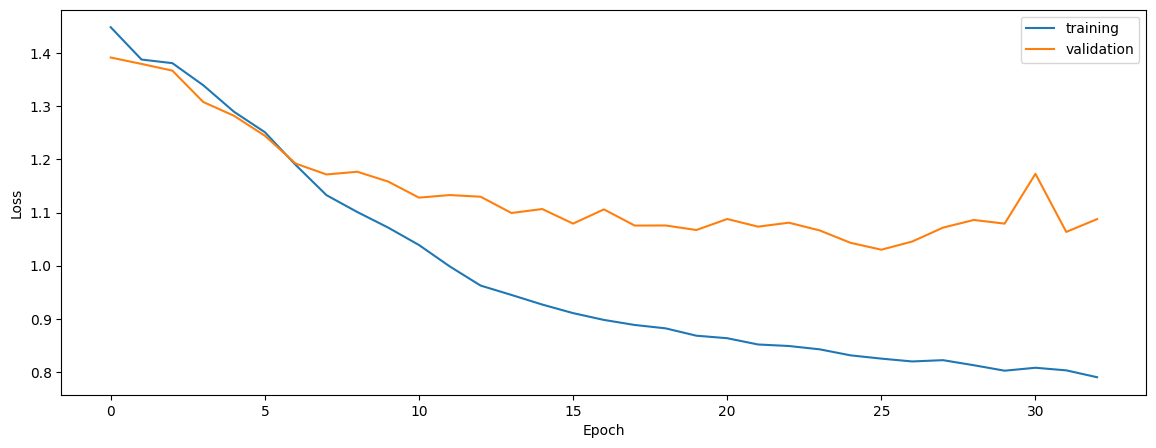

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6792942050830261
0.6400262190696913
0.682513532595905


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.6792942050830261
0.6400262190696913
0.682513532595905


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6780054644808743
0.6391136801541426
0.6941036802532647


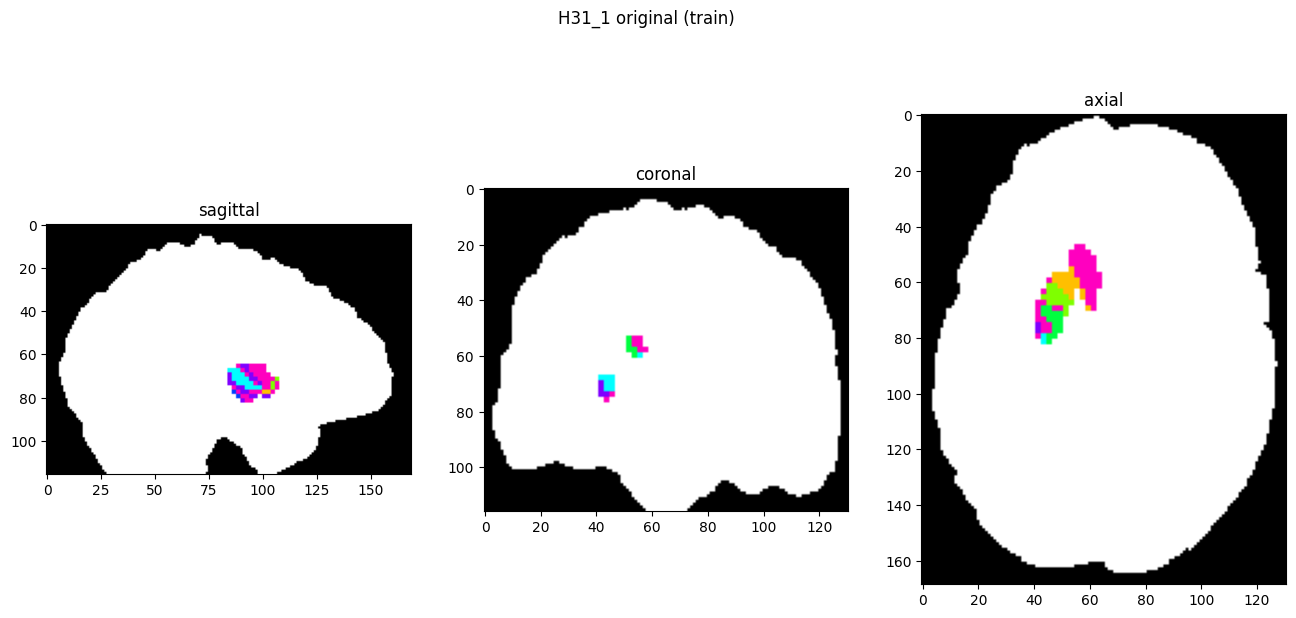

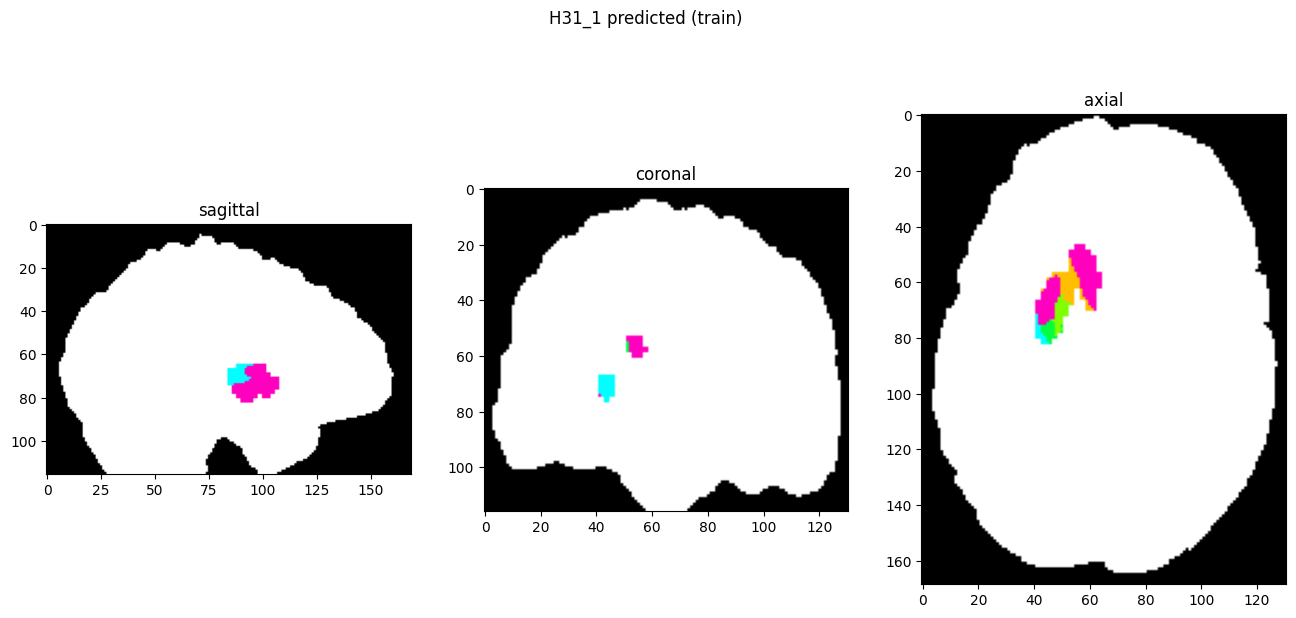

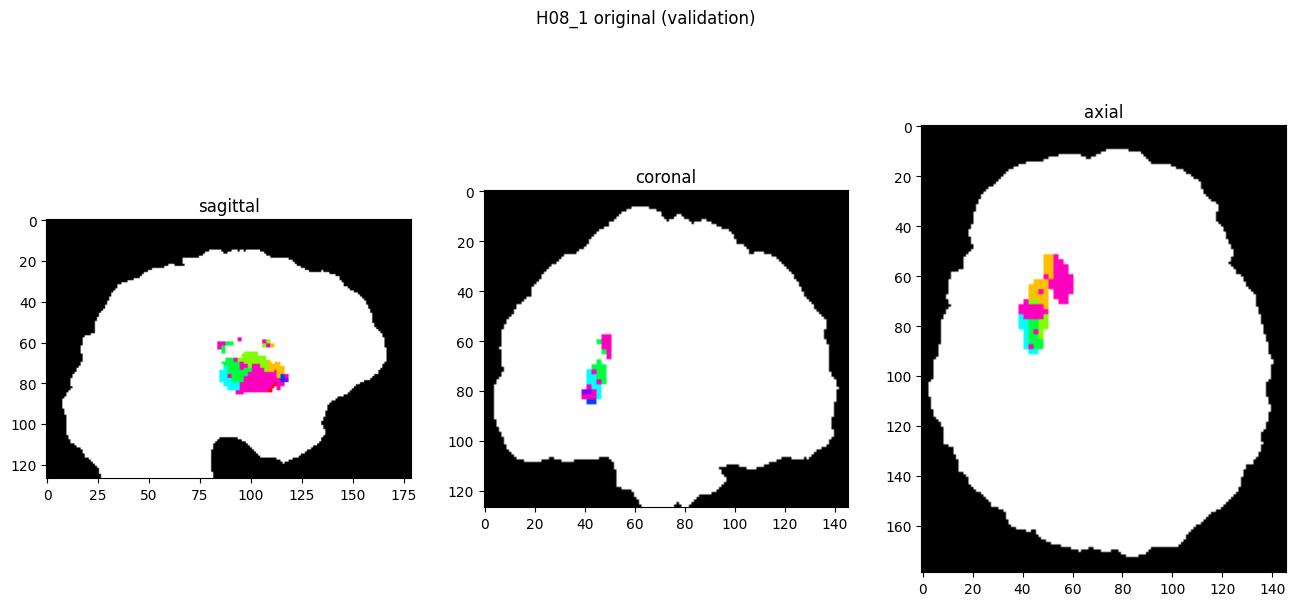

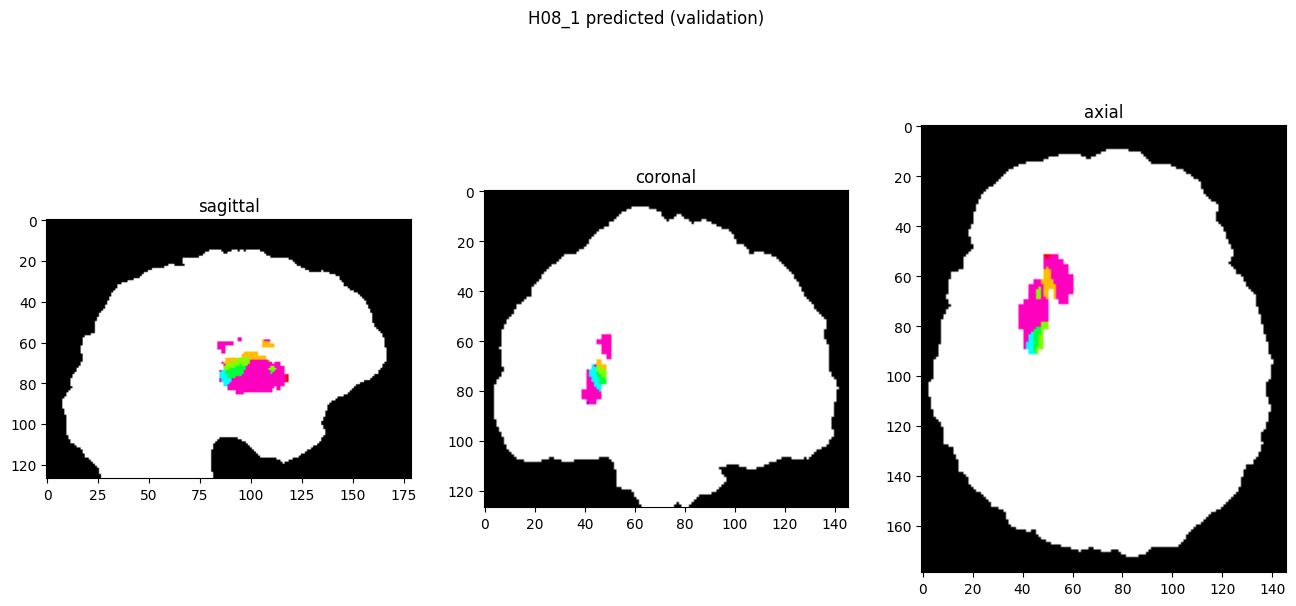

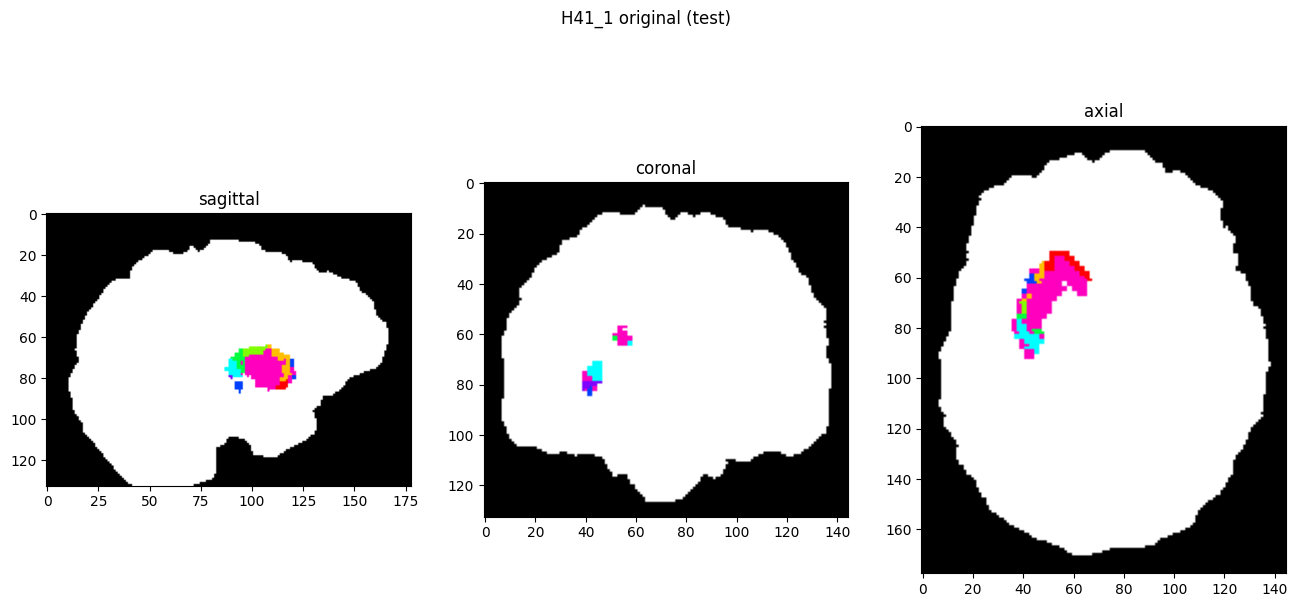

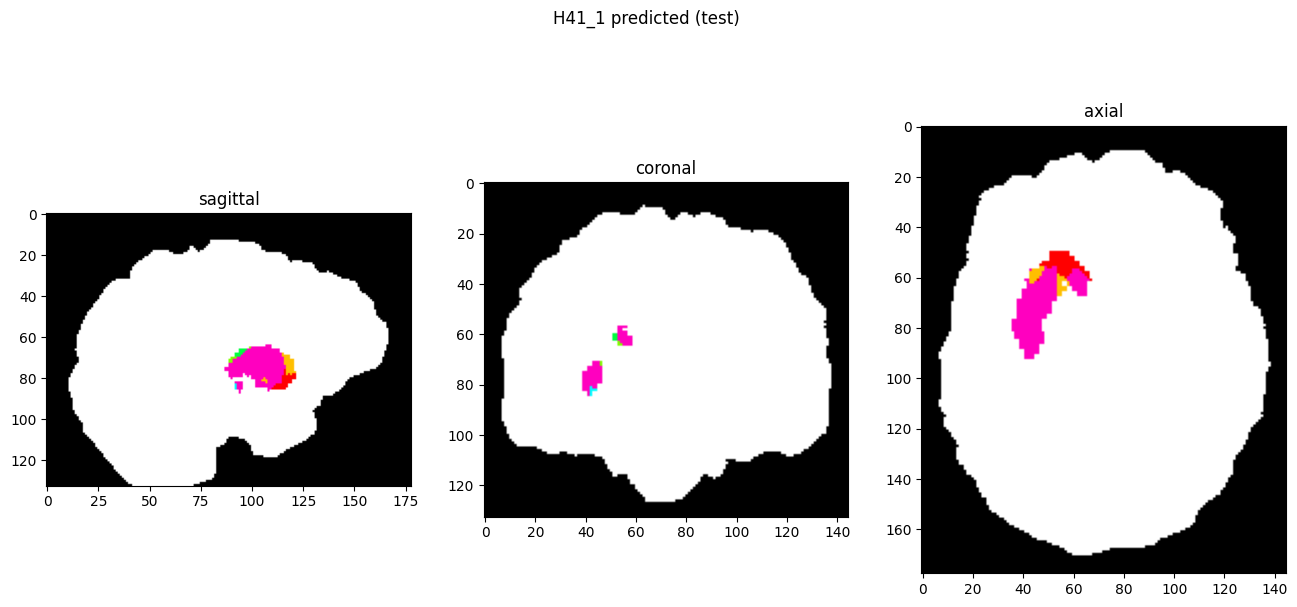

In [10]:
showResults(model, gen, threshold=0)